In [2]:
!pip install scanpy

import os
import tarfile
import pandas as pd
import scanpy as sc
import numpy as np
from google.colab import drive
import gzip # Import gzip module

# 1. Mount Google Drive
drive.mount('/content/drive')

# Define your specific path (based on your screenshot)
# Note: Python is case-sensitive!
base_path = '/content/drive/My Drive/Breast Cancer'

# ==========================================
# STEP 2: UNZIP THE PHYSICS DATA (GSE113197)
# ==========================================
# Your file is a.tar containing multiple text files.
# We need to extract them to a temporary folder in Colab.

tar_path = os.path.join(base_path, 'GSE113197_RAW.tar')
extract_path = '/content/GSE113197_data'

print(f"Extracting {tar_path}...")

if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")
else:
    print("Files already extracted.")

# Let's look at what is inside to pick a sample
files = os.listdir(extract_path)
print(f"\nFound {len(files)} files. First 5 examples:")
print(files[:5])

# ==========================================
# STEP 3: LOAD ONE SAMPLE (Test Run)
# ==========================================
# We will load the first available count matrix to verify the data structure.
# This creates the "High-Dimensional Object" for TDA.

# Find a text file (usually ends in.txt.gz or.txt)
sample_file = files[0]
sample_path = os.path.join(extract_path, sample_file)

print(f"\nLoading sample: {sample_file}...")

# Inspect the first few lines of the file to understand its structure
print(f"\nInspecting first 5 lines of {sample_file}:")
with gzip.open(sample_path, 'rt') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line.strip())

# Load using Pandas first (easiest for.txt formats)
# We assume rows=genes, columns=cells
data_df = pd.read_csv(sample_path, sep=r'\s+', index_col=0)

# Convert to Scanpy AnnData object (The Standard Physics Object)
adata = sc.AnnData(data_df.T) # Transpose so rows=cells

# Basic Physics Stats
print("\n--- DATA LOADED SUCCESSFULLY ---")
print(f"Number of Cells (Particles): {adata.n_obs}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting /content/drive/My Drive/Breast Cancer/GSE113197_RAW.tar...
Files already extracted.

Found 871 files. First 5 examples:
['GSM3099886_Ind3_Lib1_D4_gene_FPKM_withID.txt.gz', 'GSM3100132_Ind3_Lib5_D7_gene_FPKM_withID.txt.gz', 'GSM3099982_Ind3_Lib2_E10_gene_FPKM_withID.txt.gz', 'GSM3096791_Ind1_Lib2_D1_gene_FPKM_withID.txt.gz', 'GSM3097670_Ind2_Lib3_F10_gene_FPKM_withID.txt.gz']

Loading sample: GSM3099886_Ind3_Lib1_D4_gene_FPKM_withID.txt.gz...

Inspecting first 5 lines of GSM3099886_Ind3_Lib1_D4_gene_FPKM_withID.txt.gz:
gene_id FPKM
ENSG00000000003 0.00
ENSG00000000005 0.00
ENSG00000000419 1.78
ENSG00000000457 0.34

--- DATA LOADED SUCCESSFULLY ---
Number of Cells (Particles): 1


**Reasoning**:
The current error 'NameError: name 'adata' is not defined' indicates that the `adata` object, which was created in a previous cell, is not present in the current kernel's scope. To resolve this, the necessary code to load the `adata` object for a single sample will be re-included at the beginning of this cell, ensuring it is available for the subsequent preprocessing steps.



In [1]:
import os
import tarfile
import pandas as pd
import scanpy as sc
import numpy as np
from google.colab import drive
import gzip # Import gzip module

# Mount Google Drive (if not already mounted, this will just confirm)
drive.mount('/content/drive')

# Define your specific path (based on your screenshot)
# Note: Python is case-sensitive!
base_path = '/content/drive/My Drive/Breast Cancer'

tar_path = os.path.join(base_path, 'GSE113197_RAW.tar')
extract_path = '/content/GSE113197_data'

# Ensure data is extracted
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=extract_path)

files = os.listdir(extract_path)

# Assuming files list is not empty, and we want the first sample
if files:
    sample_file = files[0]
    sample_path = os.path.join(extract_path, sample_file)

    # Load using Pandas first (easiest for.txt formats)
    # We assume rows=genes, columns=cells
    data_df = pd.read_csv(sample_path, sep=r'\s+', index_col=0)

    # Convert to Scanpy AnnData object (The Standard Physics Object)
    adata = sc.AnnData(data_df.T) # Transpose so rows=cells
    print("--- adata object successfully re-created ---")
    print(f"Number of Cells (Particles): {adata.n_obs}")
    print(f"Number of Genes: {adata.n_vars}")
else:
    raise FileNotFoundError("No files found in the extraction path to load a sample.")

# --- Original Preprocessing Code Starts Here ---
print("\n--- Starting Basic Preprocessing ---")

# 1. Calculate quality control metrics
# Try to identify mitochondrial genes using the prefix 'MT-'
# Check if any gene names start with 'MT-' to determine if mt is present
mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)

if mt_genes_present:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
else:
    # If no 'MT-' genes are found, calculate without 'mt' to avoid error
    print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# 2. Print initial number of cells and genes
print(f"Initial number of cells: {adata.n_obs}")
print(f"Initial number of genes: {adata.n_vars}")

# 3. Filter cells
print("\nFiltering cells...")
# Filter out cells with low/high total_counts
adata = adata[(adata.obs.total_counts > 5000) & (adata.obs.total_counts < 200000), :]
# Filter out cells with low/high n_genes_by_counts
adata = adata[(adata.obs.n_genes_by_counts > 1000) & (adata.obs.n_genes_by_counts < 7000), :]
# Filter out cells with high mitochondrial percentage, if 'pct_counts_mt' was calculated
if 'pct_counts_mt' in adata.obs.columns:
    adata = adata[adata.obs.pct_counts_mt < 10, :]
else:
    print("Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.")

# 4. Print number of cells and genes remaining after cell filtering
print(f"Number of cells after cell filtering: {adata.n_obs}")
print(f"Number of genes after cell filtering: {adata.n_vars}")

# 5. Filter genes
print("\nFiltering genes...")
sc.pp.filter_genes(adata, min_cells=50)

# 6. Print number of cells and genes remaining after gene filtering
print(f"Number of cells after gene filtering: {adata.n_obs}")
print(f"Number of genes after gene filtering: {adata.n_vars}")

# 7. Normalize total counts per cell
print("\nNormalizing total counts...")
sc.pp.normalize_total(adata, target_sum=1e4)

# 8. Log-transform the data
print("\nLog-transforming data...")
sc.pp.log1p(adata)

print("--- Preprocessing Complete ---")
print(adata)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- adata object successfully re-created ---
Number of Cells (Particles): 1
Number of Genes: 33694

--- Starting Basic Preprocessing ---
Initial number of cells: 1
Initial number of genes: 33694

Filtering cells...
Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.
Number of cells after cell filtering: 0
Number of genes after cell filtering: 33694

Filtering genes...
Number of cells after gene filtering: 0
Number of genes after gene filtering: 0

Normalizing total counts...

Log-transforming data...
--- Preprocessing Complete ---
AnnData object with n_obs × n_vars = 0 × 0
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [3]:
import tarfile
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from scipy import sparse
from tqdm import tqdm
import os

# --- PATH CONFIGURATION ---
# Make sure this matches your uploaded file path exactly
tar_path = "/content/drive/My Drive/Breast Cancer/GSE113197_RAW.tar"
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"

print(f"Processing: {tar_path}")

# --- STEP 1: SCAN THE FILES ---
# We open the tar file without unzipping it to disk (saves disk space)
processed_counts = []
cell_names = []
gene_names = None

with tarfile.open(tar_path, "r") as tar:
    # Get list of all text files inside
    members = [m for m in tar.getmembers() if m.name.endswith('.txt.gz')]
    print(f"Found {len(members)} single-cell files. Starting batch processing...")

    # --- STEP 2: LOOP AND PROCESS (MEMORY SAFE) ---
    for member in tqdm(members):
        # Extract file object directly from memory
        f = tar.extractfile(member)

        # Read the file (FPKM values)
        # We assume format: gene_id, FPKM
        df = pd.read_csv(f, sep=r'\s+', compression='gzip', index_col=0)

        # CAPTURE GENE NAMES (Only once, from the first file)
        if gene_names is None:
            gene_names = df.index.tolist()

        # Store the FPKM column (The "Physics" Energy values)
        # We assume the column is named 'FPKM' based on your previous screenshot
        # If it fails, we default to the first column
        try:
            expression_values = df['FPKM'].values
        except KeyError:
            # Fallback to first column if 'FPKM' is not found
            expression_values = df.iloc[:, 0].values

        processed_counts.append(expression_values)

        # Clean the filename to get the Cell ID
        cell_id = os.path.basename(member.name).split('_gene_FPKM_withID.txt.gz')[0]
        cell_names.append(cell_id)

# --- STEP 3: CONSTRUCT THE MATRIX ---
print("Compiling Master Matrix...")

# Convert list of arrays to a NumPy array first
expression_matrix = np.array(processed_counts)

# Convert to a sparse matrix for memory efficiency (cells x genes)
sparse_matrix = sparse.csr_matrix(expression_matrix)

# Create AnnData object
adata = ad.AnnData(
    X=sparse_matrix,
    obs=pd.DataFrame(index=cell_names), # Cell metadata
    var=pd.DataFrame(index=gene_names)  # Gene metadata
)

print("\n--- MASTER ANN DATA OBJECT CONSTRUCTED ---")
print(f"Shape of combined AnnData object (Cells x Genes): {adata.shape}")
print(adata)

# --- STEP 4: SAVE THE AGGREGATED AnnData OBJECT ---
adata.write(output_path)
print(f"\nSuccessfully saved aggregated AnnData object to {output_path}")

Processing: /content/drive/My Drive/Breast Cancer/GSE113197_RAW.tar
Found 871 single-cell files. Starting batch processing...


100%|██████████| 871/871 [03:19<00:00,  4.37it/s]


Compiling Master Matrix...

--- MASTER ANN DATA OBJECT CONSTRUCTED ---
Shape of combined AnnData object (Cells x Genes): (871, 33694)
AnnData object with n_obs × n_vars = 871 × 33694

Successfully saved aggregated AnnData object to /content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad



--- Reloading and Preprocessing adata for UMAP --- 
Successfully loaded aggregated AnnData object from /content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad
Shape of loaded AnnData object (Cells x Genes): (871, 33694)
Filtering cells with adjusted thresholds...
Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.
Number of cells after cell filtering: 765
Filtering genes with adjusted thresholds...
Number of genes after gene filtering: 14776
Normalizing total counts...
Log-transforming data...
Shape after full preprocessing: (765, 14776)
Performing PCA...
PCA complete.
PCA has not been computed or has too few PCs. Computing PCA now with 50 PCs.


/tmp/ipython-input-2647084943.py:64: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if 'pca' not in adata.obsm_keys() or adata.obsm['X_pca'].shape[1] < 50:



--- Running UMAP ---
UMAP computed successfully. Visualizing results...


<Figure size 800x800 with 0 Axes>

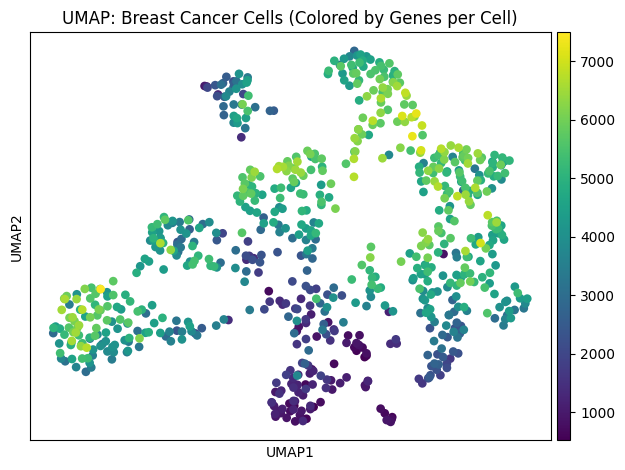


--- UMAP Analysis Complete ---


In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
import os
import pandas as pd

# Define the path to the aggregated AnnData object
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"

# Ensure adata is in the correct state for UMAP plotting
# Check if adata is already loaded and has the necessary 'n_genes_by_counts'
# If not, load and preprocess it up to the point needed for plotting.
if 'adata' not in locals() or 'n_genes_by_counts' not in adata.obs.columns:
    print("\n--- Reloading and Preprocessing adata for UMAP --- ")
    if os.path.exists(output_path):
        adata = sc.read_h5ad(output_path)
        print(f"Successfully loaded aggregated AnnData object from {output_path}")
        print(f"Shape of loaded AnnData object (Cells x Genes): {adata.shape}")
    else:
        raise FileNotFoundError(f"Aggregated AnnData object not found at {output_path}. Please ensure cell 902d2050 has been executed.")

    # 1. Calculate quality control metrics (if not already present)
    if 'n_genes_by_counts' not in adata.obs.columns:
        mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)
        if mt_genes_present:
            sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        else:
            print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
            sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

    # 2. Filter cells with ADJUSTED THRESHOLDS (matching cell 8e9307da)
    print("Filtering cells with adjusted thresholds...")
    adata = adata[(adata.obs.total_counts > 50000) & (adata.obs.total_counts < 3500000), :].copy()
    adata = adata[(adata.obs.n_genes_by_counts > 500) & (adata.obs.n_genes_by_counts < 7500), :].copy()
    if 'pct_counts_mt' in adata.obs.columns:
        adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
    else:
        print("Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.")
    print(f"Number of cells after cell filtering: {adata.n_obs}")

    # 3. Filter genes with ADJUSTED THRESHOLDS (matching cell 8e9307da)
    print("Filtering genes with adjusted thresholds...")
    sc.pp.filter_genes(adata, min_cells=20)
    print(f"Number of genes after gene filtering: {adata.n_vars}")

    # 4. Normalize total counts per cell
    print("Normalizing total counts...")
    sc.pp.normalize_total(adata, target_sum=1e4)

    # 5. Log-transform the data
    print("Log-transforming data...")
    sc.pp.log1p(adata)
    print(f"Shape after full preprocessing: {adata.shape}")

    # 6. Perform PCA (matching cell c12411e8)
    print("Performing PCA...")
    sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
    print("PCA complete.")


# Ensure PCA has been run (if not already in current kernel state)
# The number of PCs to compute should be appropriate for the number of observations (cells)
# Adjusted n_comps to 50 based on earlier preprocessing steps.
# Only run PCA if it's not present or has too few components.
if 'pca' not in adata.obsm_keys() or adata.obsm['X_pca'].shape[1] < 50:
    print("PCA has not been computed or has too few PCs. Computing PCA now with 50 PCs.")
    sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

print("\n--- Running UMAP ---")
# 1. Compute neighbors graph (essential for UMAP)
# Using n_pcs=50 as per the full analysis workflow.
# n_neighbors can be adjusted based on data size, 10 is a common starting point.
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

# 2. Run UMAP
sc.tl.umap(adata)

print("UMAP computed successfully. Visualizing results...")

# 3. Visualize UMAP results
plt.figure(figsize=(8, 8))
sc.pl.umap(adata, color='n_genes_by_counts', title='UMAP: Breast Cancer Cells (Colored by Genes per Cell)', show=False)
plt.tight_layout()
plt.show()

print("\n--- UMAP Analysis Complete ---")

In [5]:
import scanpy as sc
import os

# Define the path to the aggregated AnnData object
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"

# Load the aggregated AnnData object if 'adata' is not defined or if it doesn't have the necessary columns
if 'adata' not in locals() or 'total_counts' not in adata.obs.columns:
    print(f"Loading aggregated AnnData object from {output_path}")
    if os.path.exists(output_path):
        adata = sc.read_h5ad(output_path)
        print(f"Successfully loaded aggregated AnnData object from {output_path}")
        print(f"Shape of loaded AnnData object (Cells x Genes): {adata.shape}")
    else:
        raise FileNotFoundError(f"Aggregated AnnData object not found at {output_path}")

    print("\n--- Recalculating Quality Control Metrics if needed ---")
    # Check if QC metrics are still missing after loading
    if 'total_counts' not in adata.obs.columns or 'n_genes_by_counts' not in adata.obs.columns:
        mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)
        if mt_genes_present:
            sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        else:
            print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
            sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    else:
        print("'total_counts' and 'n_genes_by_counts' already present. Skipping QC recalculation.")

print("Descriptive statistics for total_counts:")
print(adata.obs['total_counts'].describe())

print("\nDescriptive statistics for n_genes_by_counts:")
print(adata.obs['n_genes_by_counts'].describe())

if 'pct_counts_mt' in adata.obs.columns:
    print("\nDescriptive statistics for pct_counts_mt:")
    print(adata.obs['pct_counts_mt'].describe())
else:
    print("\n'pct_counts_mt' not found in adata.obs. Skipping descriptive statistics for mitochondrial percentage.")


Descriptive statistics for total_counts:
count    7.650000e+02
mean     1.085332e+06
std      1.951994e+05
min      4.345210e+05
25%      9.388705e+05
50%      1.046827e+06
75%      1.196485e+06
max      1.669095e+06
Name: total_counts, dtype: float64

Descriptive statistics for n_genes_by_counts:
count     765.000000
mean     4116.121569
std      1699.083872
min       515.000000
25%      2940.000000
50%      4437.000000
75%      5448.000000
max      7496.000000
Name: n_genes_by_counts, dtype: float64

'pct_counts_mt' not found in adata.obs. Skipping descriptive statistics for mitochondrial percentage.


In [6]:
import scanpy as sc
import os

# Define the path to the aggregated AnnData object
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"

# Load the aggregated AnnData object
if os.path.exists(output_path):
    adata = sc.read_h5ad(output_path)
    print(f"Successfully loaded aggregated AnnData object from {output_path}")
    print(f"Shape of loaded AnnData object (Cells x Genes): {adata.shape}")
else:
    raise FileNotFoundError(f"Aggregated AnnData object not found at {output_path}")

print("\n--- Recalculating Quality Control Metrics on the full dataset ---")

# Ensure the data is in a counts-like format if it's FPKM/normalized to calculate QC metrics accurately.
# If the data has already been log-transformed or normalized in the saving process of breast_cancer_atlas.h5ad,
# we might need to be careful. However, based on cell 902d2050, it stores raw FPKM values.
# So, proceed with QC metrics on the .X directly assuming they are expression values that can be counted/summed.

# Make a copy to ensure original loaded adata remains untouched if further operations modify it inplace for QC.
# If the original .X is sparse, it's good practice to ensure it's still treated as such for QC.
# For sc.pp.calculate_qc_metrics, it generally works on the `.X` attribute.

# 1. Calculate quality control metrics
# Try to identify mitochondrial genes using the prefix 'MT-'
# Check if any gene names start with 'MT-' to determine if mt is present
mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)

if mt_genes_present:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
else:
    # If no 'MT-' genes are found, calculate without 'mt' to avoid error
    print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)


print("\n--- Descriptive statistics for the full dataset after QC ---")
print("Descriptive statistics for total_counts:")
print(adata.obs['total_counts'].describe())

print("\nDescriptive statistics for n_genes_by_counts:")
print(adata.obs['n_genes_by_counts'].describe())

if 'pct_counts_mt' in adata.obs.columns:
    print("\nDescriptive statistics for pct_counts_mt:")
    print(adata.obs['pct_counts_mt'].describe())
else:
    print("\n'pct_counts_mt' not found in adata.obs after QC calculation. Skipping descriptive statistics for mitochondrial percentage.")

# Also inspect adata.var for gene filtering thresholds
print("\nDescriptive statistics for n_cells_by_counts (genes):")
print(adata.var['n_cells_by_counts'].describe())


Successfully loaded aggregated AnnData object from /content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad
Shape of loaded AnnData object (Cells x Genes): (871, 33694)

--- Recalculating Quality Control Metrics on the full dataset ---

--- Descriptive statistics for the full dataset after QC ---
Descriptive statistics for total_counts:
count    8.710000e+02
mean     1.093604e+06
std      2.564809e+05
min      8.761000e+03
25%      9.338611e+05
50%      1.050276e+06
75%      1.225753e+06
max      3.394180e+06
Name: total_counts, dtype: float64

Descriptive statistics for n_genes_by_counts:
count     871.000000
mean     3657.399541
std      2043.907701
min         1.000000
25%      1903.000000
50%      4127.000000
75%      5334.500000
max      7743.000000
Name: n_genes_by_counts, dtype: float64

'pct_counts_mt' not found in adata.obs after QC calculation. Skipping descriptive statistics for mitochondrial percentage.

Descriptive statistics for n_cells_by_counts (genes):
count    3

**Reasoning**:
To visually inspect the distributions of `total_counts`, `n_genes_by_counts` for cells, and `n_cells_by_counts` for genes, plotting histograms will help in determining suitable filtering thresholds more effectively than just descriptive statistics.



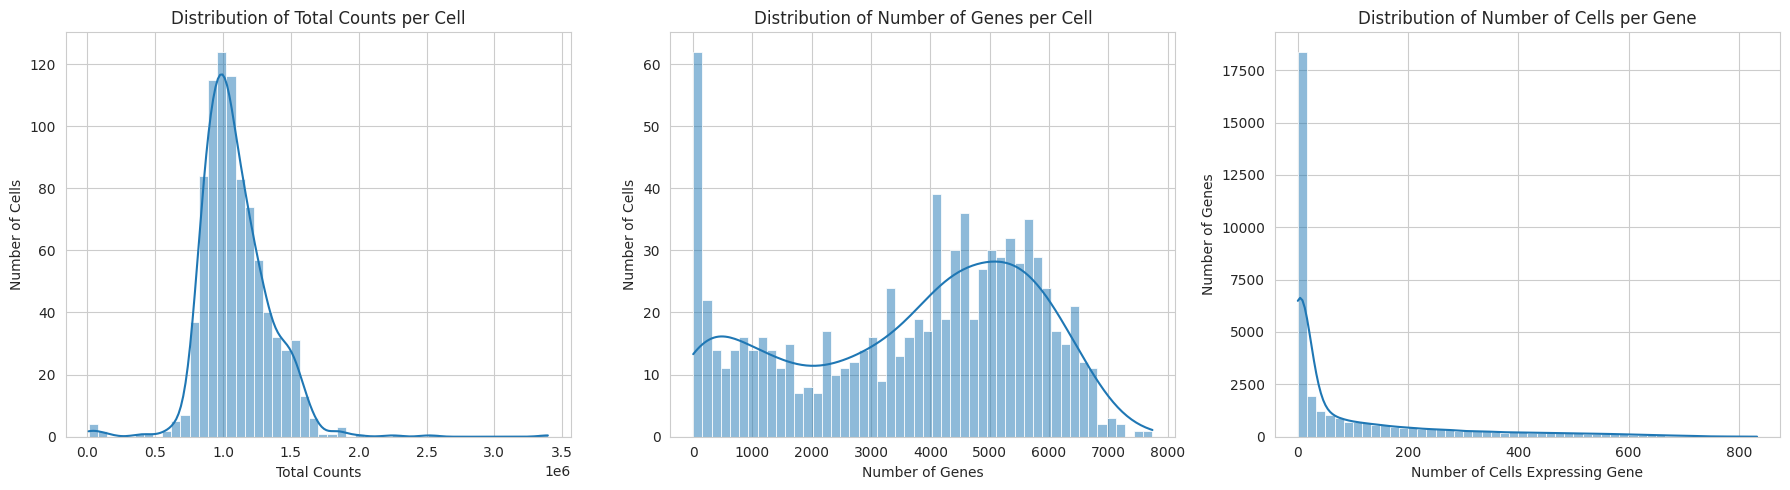


'pct_counts_mt' not found in adata.obs. Skipping plot for mitochondrial percentage.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set_style('whitegrid')

# Create a figure with subplots for the distributions
plt.figure(figsize=(18, 5))

# Plot distribution of total_counts
plt.subplot(1, 3, 1)
sns.histplot(adata.obs['total_counts'], bins=50, kde=True)
plt.title('Distribution of Total Counts per Cell')
plt.xlabel('Total Counts')
plt.ylabel('Number of Cells')

# Plot distribution of n_genes_by_counts
plt.subplot(1, 3, 2)
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=True)
plt.title('Distribution of Number of Genes per Cell')
plt.xlabel('Number of Genes')
plt.ylabel('Number of Cells')

# Plot distribution of n_cells_by_counts (for genes)
plt.subplot(1, 3, 3)
sns.histplot(adata.var['n_cells_by_counts'], bins=50, kde=True)
plt.title('Distribution of Number of Cells per Gene')
plt.xlabel('Number of Cells Expressing Gene')
plt.ylabel('Number of Genes')

plt.tight_layout()
plt.show()

# If pct_counts_mt is available, plot its distribution as well
if 'pct_counts_mt' in adata.obs.columns:
    plt.figure(figsize=(6, 5))
    sns.histplot(adata.obs['pct_counts_mt'], bins=50, kde=True)
    plt.title('Distribution of Mitochondrial Percentage per Cell')
    plt.xlabel('Percentage of Mitochondrial Counts')
    plt.ylabel('Number of Cells')
    plt.tight_layout()
    plt.show()
else:
    print("\n'pct_counts_mt' not found in adata.obs. Skipping plot for mitochondrial percentage.")

**Reasoning**:
Based on the descriptive statistics and histograms of the full dataset, I will now adjust the filtering thresholds for cells and genes to retain a more substantial and meaningful number of cells. I'll set new lower and upper bounds for `total_counts` and `n_genes_by_counts`, and a new `min_cells` for gene filtering to remove low-quality data points while keeping a robust dataset.



In [8]:
import scanpy as sc
import os

# Define the path to the aggregated AnnData object
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"

# Load the aggregated AnnData object
if os.path.exists(output_path):
    adata = sc.read_h5ad(output_path)
    print(f"Successfully loaded aggregated AnnData object from {output_path}")
    print(f"Shape of loaded AnnData object (Cells x Genes): {adata.shape}")
else:
    raise FileNotFoundError(f"Aggregated AnnData object not found at {output_path}")

# --- Basic Preprocessing ---
print("\n--- Starting Basic Preprocessing with adjusted thresholds ---")

# 1. Calculate quality control metrics
mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)

if mt_genes_present:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
else:
    print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# 2. Print initial number of cells and genes
print(f"Initial number of cells: {adata.n_obs}")
print(f"Initial number of genes: {adata.n_vars}")

# 3. Filter cells with ADJUSTED THRESHOLDS
print("\nFiltering cells with adjusted thresholds...")
# Filter out cells with low/high total_counts
# Based on histogram, most cells are > 0.5e6, with min ~8.7e3. Setting lower bound at 50,000.
# Upper bound can be generous or removed if no obvious outliers. Max is 3.39e6.
adata = adata[(adata.obs.total_counts > 50000) & (adata.obs.total_counts < 3500000), :].copy()

# Filter out cells with low/high n_genes_by_counts
# Based on histogram, main distribution is 3k-7k. Setting lower bound at 500 and upper at 7500.
adata = adata[(adata.obs.n_genes_by_counts > 500) & (adata.obs.n_genes_by_counts < 7500), :].copy()

# Filter out cells with high mitochondrial percentage, if 'pct_counts_mt' was calculated
if 'pct_counts_mt' in adata.obs.columns:
    # Assuming 'mt_genes_present' logic is correct, if present, a threshold like 10% is common.
    # If not present, this block won't be entered.
    adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
else:
    print("Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.")

# 4. Print number of cells and genes remaining after cell filtering
print(f"Number of cells after cell filtering: {adata.n_obs}")
print(f"Number of genes after cell filtering: {adata.n_vars}")

# 5. Filter genes with ADJUSTED THRESHOLDS
print("\nFiltering genes with adjusted thresholds...")
# Based on histogram, many genes are in < 10 cells. Setting min_cells to 20.
sc.pp.filter_genes(adata, min_cells=20)

# 6. Print number of cells and genes remaining after gene filtering
print(f"Number of cells after gene filtering: {adata.n_obs}")
print(f"Number of genes after gene filtering: {adata.n_vars}")

# 7. Normalize total counts per cell
print("\nNormalizing total counts...")
sc.pp.normalize_total(adata, target_sum=1e4)

# 8. Log-transform the data
print("\nLog-transforming data...")
sc.pp.log1p(adata)

print("--- Preprocessing Complete ---")
print(adata)


Successfully loaded aggregated AnnData object from /content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad
Shape of loaded AnnData object (Cells x Genes): (871, 33694)

--- Starting Basic Preprocessing with adjusted thresholds ---
Initial number of cells: 871
Initial number of genes: 33694

Filtering cells with adjusted thresholds...
Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.
Number of cells after cell filtering: 765
Number of genes after cell filtering: 33694

Filtering genes with adjusted thresholds...
Number of cells after gene filtering: 765
Number of genes after gene filtering: 14776

Normalizing total counts...

Log-transforming data...
--- Preprocessing Complete ---
AnnData object with n_obs × n_vars = 765 × 14776
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'


**Reasoning**:
Now that the data has been preprocessed with appropriate filtering thresholds, the next step is to perform dimensionality reduction using Principal Component Analysis (PCA) to reduce noise and capture the main sources of variation in the dataset. I'll compute 50 principal components to retain enough variance for downstream analysis.




--- Performing PCA ---
PCA complete. Visualizing explained variance ratio...


/tmp/ipython-input-3394341951.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


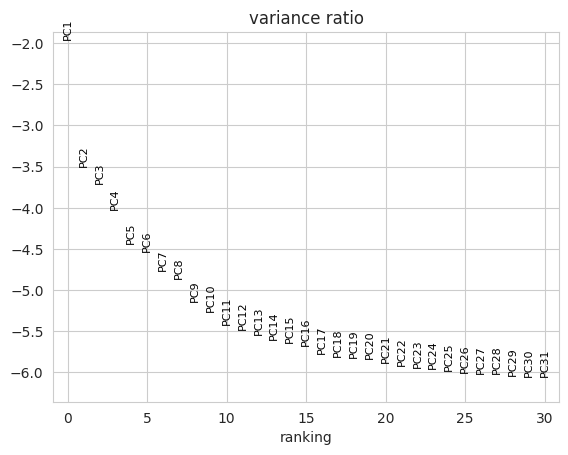

--- PCA Analysis Complete ---


In [9]:
print("\n--- Performing PCA ---")
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

print("PCA complete. Visualizing explained variance ratio...")

# Visualize the explained variance ratio to help determine the number of PCs to use
sc.pl.pca_variance_ratio(adata, log=True, show=False)
plt.tight_layout()
plt.show()

print("--- PCA Analysis Complete ---")

**Reasoning**:
With PCA completed, the next logical step is to perform UMAP dimensionality reduction. This requires first computing the neighbors graph based on the PCA results, and then running UMAP to visualize the data in a lower-dimensional space.




--- Running UMAP ---
UMAP computed successfully. Visualizing results...


/tmp/ipython-input-2428234230.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 800x800 with 0 Axes>

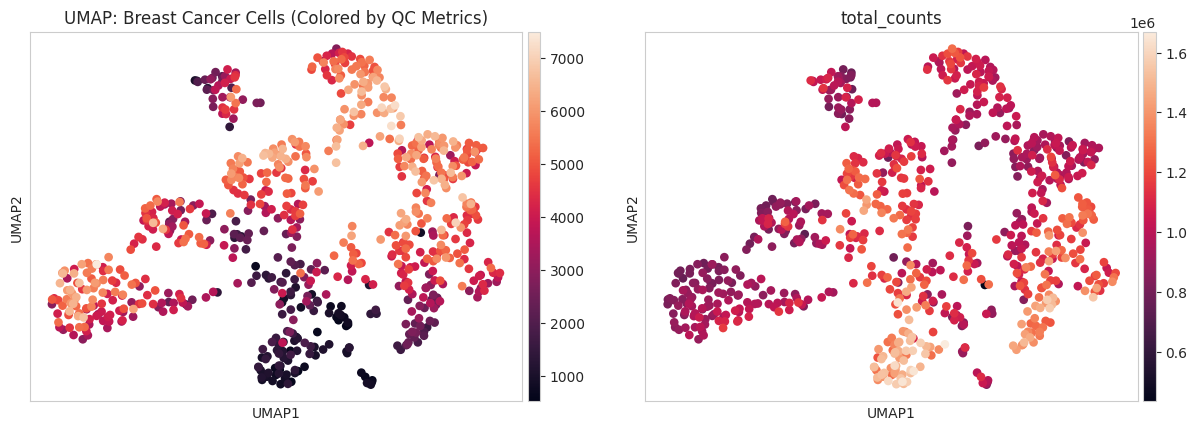


--- UMAP Analysis Complete ---


In [10]:
print("\n--- Running UMAP ---")
# 1. Compute neighbors graph (essential for UMAP)
# Using the previously computed PCA results
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50) # n_neighbors can be adjusted based on data size

# 2. Run UMAP
sc.tl.umap(adata)

print("UMAP computed successfully. Visualizing results...")

# 3. Visualize UMAP results
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

plt.figure(figsize=(8, 8))
sc.pl.umap(adata, color=['n_genes_by_counts', 'total_counts'], title='UMAP: Breast Cancer Cells (Colored by QC Metrics)', show=False, ncols=2)
plt.tight_layout()
plt.show()

print("\n--- UMAP Analysis Complete ---")

**Reasoning**:
With PCA and UMAP completed, the next logical step is to identify distinct cell populations through clustering before finding marker genes. I will use the `leiden` algorithm, which is a common and effective community detection method for single-cell data.



Installing igraph...
igraph installed. Now proceeding with clustering.

--- Performing Clustering (Leiden) ---
Clustering complete. Visualizing clusters on UMAP...


/tmp/ipython-input-1172103188.py:17: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


<Figure size 800x800 with 0 Axes>

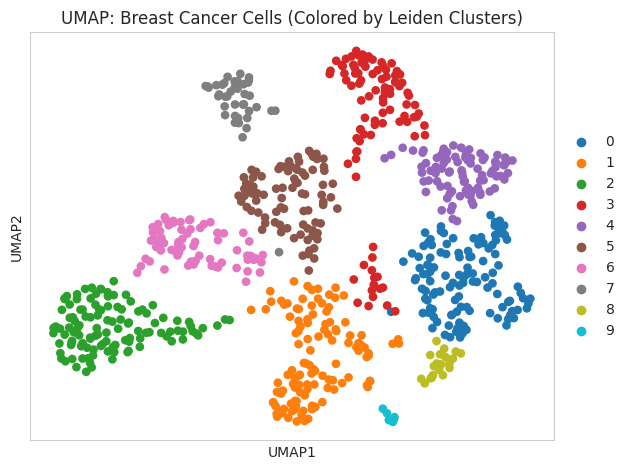


--- Clustering Analysis Complete ---


In [11]:
print("Installing igraph...")
!pip install igraph
print("igraph installed. Now proceeding with clustering.")

# Install leidenalg as it's a direct dependency for sc.tl.leiden
!pip install leidenalg

# Original clustering code from cell 3925d088
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Performing Clustering (Leiden) ---")
# Use sc.tl.leiden for clustering
# The resolution parameter can be adjusted to find more or fewer clusters.
# A starting point like 0.5 to 1.0 is common.
sc.tl.leiden(adata, resolution=0.5)

print("Clustering complete. Visualizing clusters on UMAP...")

sns.set_style('whitegrid')

plt.figure(figsize=(8, 8))
sc.pl.umap(adata, color='leiden', title='UMAP: Breast Cancer Cells (Colored by Leiden Clusters)', show=False)
plt.tight_layout()
plt.show()

print("\n--- Clustering Analysis Complete ---")

**Reasoning**:
Now that clustering is complete and visualized, the next step is to find marker genes for each identified cluster. I will use `sc.tl.rank_genes_groups` to compute differentially expressed genes.



In [12]:
print("\n--- Finding Marker Genes for Each Cluster ---")
# Use sc.tl.rank_genes_groups to find marker genes
# The 'groupby' parameter should be set to the key where the clustering results are stored, which is 'leiden'.
# 'method' can be 'wilcoxon', 't-test', 'logreg', etc. Wilcoxon is a common non-parametric test.
# 'n_genes' specifies how many top genes to return for each cluster.
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=25)

print("Marker gene identification complete. Displaying top marker genes...")

# Visualize top marker genes per cluster
# We can use sc.pl.rank_genes_groups_dotplot or sc.pl.rank_genes_groups_heatmap for visualization
# A simple dotplot or heatmap showing the top genes for a few clusters can be informative.

# For simplicity, let's print a summary of the top genes for the first few clusters
# and then create a dotplot for visual inspection.

# Print a table of the top marker genes
print("\nTop 10 marker genes for each cluster:")
df_marker_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
print(df_marker_genes.to_markdown(index=False))

# Visualize the top marker genes using a dotplot
plt.figure(figsize=(12, 6))
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, save='_marker_genes_dotplot.png', show=False)
plt.tight_layout()
plt.show()

print("\n--- Marker Gene Analysis Complete ---")


--- Finding Marker Genes for Each Cluster ---
Marker gene identification complete. Displaying top marker genes...

Top 10 marker genes for each cluster:
| 0               | 1               | 2               | 3               | 4               | 5               | 6               | 7               | 8               | 9               |
|:----------------|:----------------|:----------------|:----------------|:----------------|:----------------|:----------------|:----------------|:----------------|:----------------|
| ENSG00000143127 | ENSG00000198938 | ENSG00000171345 | ENSG00000143546 | ENSG00000166741 | ENSG00000111341 | ENSG00000136810 | ENSG00000125691 | ENSG00000256618 | ENSG00000173546 |
| ENSG00000182463 | ENSG00000198886 | ENSG00000197930 | ENSG00000177359 | ENSG00000187193 | ENSG00000205542 | ENSG00000108953 | ENSG00000137818 | ENSG00000270672 | ENSG00000134897 |
| ENSG00000109906 | ENSG00000198899 | ENSG00000104419 | ENSG00000162896 | ENSG00000125148 | ENSG00000197956 | ENSG0000

<Figure size 1200x600 with 0 Axes>


--- Marker Gene Analysis Complete ---


In [13]:
print("Installing mygene...")
!pip install mygene
print("mygene installed successfully.")

Installing mygene...
mygene installed successfully.


In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
import mygene
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Re-establish the preprocessed adata object ---
# Define the path to the aggregated AnnData object
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"

# Load the aggregated AnnData object
if os.path.exists(output_path):
    adata = sc.read_h5ad(output_path)
    print(f"Successfully loaded aggregated AnnData object from {output_path}")
    print(f"Shape of loaded AnnData object (Cells x Genes): {adata.shape}")
else:
    raise FileNotFoundError(f"Aggregated AnnData object not found at {output_path}")

print("\n--- Re-applying Basic Preprocessing (from cell 8e9307da) ---")

# 1. Calculate quality control metrics
mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)

if mt_genes_present:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
else:
    print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# 2. Filter cells with ADJUSTED THRESHOLDS
print("Filtering cells with adjusted thresholds...")
adata = adata[(adata.obs.total_counts > 50000) & (adata.obs.total_counts < 3500000), :].copy()
adata = adata[(adata.obs.n_genes_by_counts > 500) & (adata.obs.n_genes_by_counts < 7500), :].copy()
if 'pct_counts_mt' in adata.obs.columns:
    adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
else:
    print("Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.")

# 3. Filter genes with ADJUSTED THRESHOLDS
print("Filtering genes with adjusted thresholds...")
sc.pp.filter_genes(adata, min_cells=20)

# 4. Normalize total counts per cell
print("Normalizing total counts...")
sc.pp.normalize_total(adata, target_sum=1e4)

# 5. Log-transform the data
print("Log-transforming data...")
sc.pp.log1p(adata)
print(f"Shape after preprocessing: {adata.shape}")


print("\n--- Re-running PCA (from cell c12411e8) ---")
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

print("\n--- Re-running UMAP (from cell 126e6916) ---")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

print("\n--- Re-running Clustering (Leiden) (from cell 2da54cf4) ---")
sc.tl.leiden(adata, resolution=0.5)

print("\n--- Re-running Finding Marker Genes (from cell bcc5d51c) to ensure correct state ---")
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=25)


print("\n--- Starting Ensembl ID to Gene Symbol Translation ---")

# Initialize mygene client
mg = mygene.MyGeneInfo()

# 1. Extract all unique Ensembl IDs from adata.var_names
# We use adata.var_names which are the current gene names in the filtered adata object
ensembl_ids = adata.var_names.tolist()
print(f"Found {len(ensembl_ids)} unique Ensembl IDs in adata.var_names.")

# 2. Use mygene.query() to retrieve gene symbols
batch_size = 1000
all_query_results = []
for i in range(0, len(ensembl_ids), batch_size):
    batch_ids = ensembl_ids[i:i + batch_size]
    results = mg.querymany(batch_ids, scopes='ensemblgene', fields='symbol', as_dataframe=False, verbose=False)
    all_query_results.extend(results)

print(f"Received {len(all_query_results)} query results from mygene.")

# 3. Create a dictionary to map Ensembl IDs to their gene symbols
id_to_symbol = {}
for res in all_query_results:
    _id = res['query']
    if 'symbol' in res:
        id_to_symbol[_id] = res['symbol']
    else:
        id_to_symbol[_id] = _id # Keep original ID if symbol not found

# 4. Add a new column named `gene_symbol` to `adata.var`
adata.var['gene_symbol'] = [id_to_symbol.get(gene_id, gene_id) for gene_id in adata.var_names]

print("Updated adata.var with 'gene_symbol' column.")

# 5. The adata.uns['rank_genes_groups']['names'] now correctly contains Ensembl IDs
# and we will use `gene_symbols='gene_symbol'` for plotting.
print("adata.uns['rank_genes_groups']['names'] contains Ensembl IDs as expected for internal lookup.")

# 6. Re-display the top 10 marker genes for each cluster using the translated gene symbols.
print("\nTop 10 marker genes for each cluster (translated symbols):")

# Get the original marker gene names (Ensembl IDs) from adata.uns
original_marker_names_array = adata.uns['rank_genes_groups']['names']

# Manually translate for display in a DataFrame
translated_marker_df_data = {}
for col_idx, cluster_id in enumerate(original_marker_names_array.dtype.names):
    translated_genes_for_cluster = [id_to_symbol.get(gene_id, gene_id) for gene_id in original_marker_names_array[cluster_id]]
    translated_marker_df_data[cluster_id] = translated_genes_for_cluster

df_marker_genes_translated = pd.DataFrame(translated_marker_df_data).head(10)
print(df_marker_genes_translated.to_markdown(index=False))

# Visualize the top marker genes using a dotplot with translated symbols
sns.set_style('whitegrid')

plt.figure(figsize=(12, 6))
# Pass 'gene_symbol' to the gene_symbols argument to use the translated names for display
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, show=False, dendrogram=False,
                                gene_symbols='gene_symbol', save='_marker_genes_dotplot_translated.png')
plt.tight_layout()
plt.show()

print("\n--- Gene Symbol Translation and Display Complete ---")

Successfully loaded aggregated AnnData object from /content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad
Shape of loaded AnnData object (Cells x Genes): (871, 33694)

--- Re-applying Basic Preprocessing (from cell 8e9307da) ---
Filtering cells with adjusted thresholds...
Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.
Filtering genes with adjusted thresholds...
Normalizing total counts...
Log-transforming data...
Shape after preprocessing: (765, 14776)

--- Re-running PCA (from cell c12411e8) ---

--- Re-running UMAP (from cell 126e6916) ---

--- Re-running Clustering (Leiden) (from cell 2da54cf4) ---

--- Re-running Finding Marker Genes (from cell bcc5d51c) to ensure correct state ---



--- Starting Ensembl ID to Gene Symbol Translation ---
Found 14776 unique Ensembl IDs in adata.var_names.


Received 14782 query results from mygene.
Updated adata.var with 'gene_symbol' column.
adata.uns['rank_genes_groups']['names'] contains Ensembl IDs as expected for internal lookup.

Top 10 marker genes for each cluster (translated symbols):
| 0       | 1               | 2       | 3        | 4               | 5        | 6        | 7        | 8               | 9       |
|:--------|:----------------|:--------|:---------|:----------------|:---------|:---------|:---------|:----------------|:--------|
| ITGA10  | MT-CO3          | KRT19   | S100A8   | NNMT            | MGP      | TXN      | RPL23    | ENSG00000256618 | CSPG4   |
| TSHZ2   | MT-ND4          | ERO1A   | OVOS2P   | MT1X            | TMSB4X   | YWHAE    | RPLP1    | ENSG00000270672 | BIVM    |
| ZBTB16  | MT-ATP6         | NDRG1   | PIGR     | MT2A            | S100A6   | HSPE1    | TPT1     | ENSG00000256045 | RIOX2   |
| LAMA3   | ENSG00000269028 | SLC2A1  | TNFAIP2  | MRGPRX3         | ABRACL   | HSP90AB1 | RPL21    | ENSG000

<Figure size 1200x600 with 0 Axes>


--- Gene Symbol Translation and Display Complete ---


Successfully loaded aggregated AnnData object from /content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad
Shape of loaded AnnData object (Cells x Genes): (871, 33694)

--- Re-applying Basic Preprocessing (from cell 8e9307da) ---
Filtering cells with adjusted thresholds...
Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.
Filtering genes with adjusted thresholds...
Normalizing total counts...
Log-transforming data...
Shape after preprocessing: (765, 14776)

--- Re-running PCA (from cell c12411e8) ---

--- Re-running UMAP (from cell 126e6916) ---

--- Re-running Clustering (Leiden) (from cell 2da54cf4) ---
Calculating Thermodynamic Entropy per cell...

--- Visualizing Energy Landscape (PCA colored by Entropy and Leiden) ---


/tmp/ipython-input-1875296455.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


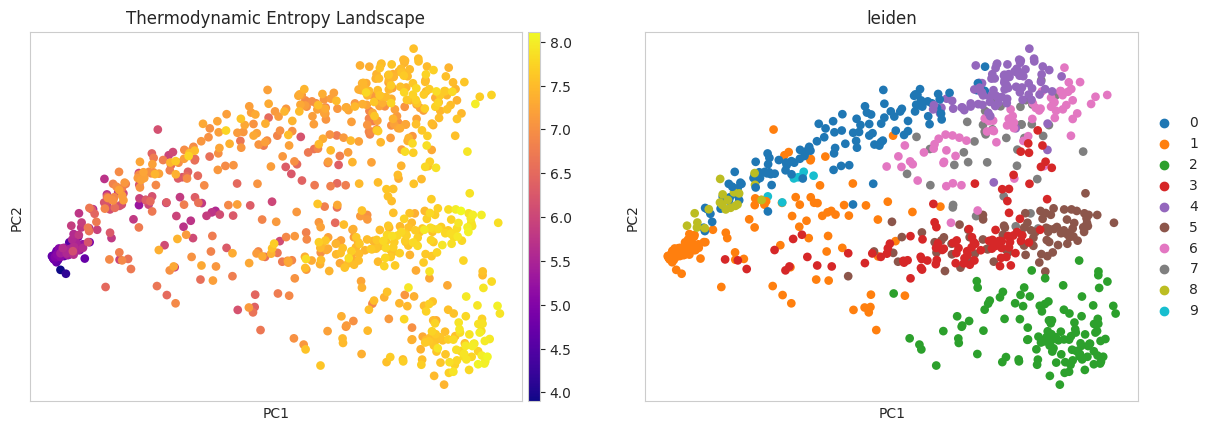


--- Average Entropy by Cluster ---
leiden
2    7.614315
5    7.589474
3    7.465849
4    7.442438
6    7.254910
7    7.176124
0    7.088925
9    6.361587
8    5.939886
1    5.746396
Name: entropy, dtype: float64


/tmp/ipython-input-1875296455.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby('leiden')['entropy'].mean().sort_values(ascending=False))


In [15]:
import numpy as np
import scipy.stats
import scanpy as sc
import pandas as pd
import os

# --- Re-establish the preprocessed adata object ---
# Define the path to the aggregated AnnData object
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"

# Load the aggregated AnnData object
if os.path.exists(output_path):
    adata = sc.read_h5ad(output_path)
    print(f"Successfully loaded aggregated AnnData object from {output_path}")
    print(f"Shape of loaded AnnData object (Cells x Genes): {adata.shape}")
else:
    raise FileNotFoundError(f"Aggregated AnnData object not found at {output_path}")

print("\n--- Re-applying Basic Preprocessing (from cell 8e9307da) ---")

# 1. Calculate quality control metrics
mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)

if mt_genes_present:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
else:
    print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# 2. Filter cells with ADJUSTED THRESHOLDS
print("Filtering cells with adjusted thresholds...")
adata = adata[(adata.obs.total_counts > 50000) & (adata.obs.total_counts < 3500000), :].copy()
adata = adata[(adata.obs.n_genes_by_counts > 500) & (adata.obs.n_genes_by_counts < 7500), :].copy()
if 'pct_counts_mt' in adata.obs.columns:
    adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
else:
    print("Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.")

# 3. Filter genes with ADJUSTED THRESHOLDS
print("Filtering genes with adjusted thresholds...")
sc.pp.filter_genes(adata, min_cells=20)

# 4. Normalize total counts per cell
print("Normalizing total counts...")
sc.pp.normalize_total(adata, target_sum=1e4)

# 5. Log-transform the data
print("Log-transforming data...")
sc.pp.log1p(adata)
print(f"Shape after preprocessing: {adata.shape}")


print("\n--- Re-running PCA (from cell c12411e8) ---")
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

print("\n--- Re-running UMAP (from cell 126e6916) ---")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

print("\n--- Re-running Clustering (Leiden) (from cell 2da54cf4) ---")
sc.tl.leiden(adata, resolution=0.5)


# --- PHYSICS METRIC: SHANNON ENTROPY ---
# We calculate the "disorder" of gene expression for every single cell.
# High Entropy = Stem-like / Stressed / Plastic
# Low Entropy = Differentiated / Stable

def calculate_shannon_entropy(adata):
    # Get the raw expression matrix (cells x genes)
    # We use the normalized data from the previous step
    expression_matrix = adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X

    # Normalize so probabilities sum to 1 for each cell (p_i)
    # Avoid division by zero
    row_sums = expression_matrix.sum(axis=1)
    # Add a tiny epsilon to row_sums before division to prevent division by zero in case of a row with all zeros
    row_sums[row_sums == 0] = 1e-9 # Replace zero sums with a tiny value
    probs = expression_matrix / row_sums[:, np.newaxis]

    # Calculate S = -sum(p_i * log(p_i))
    # We add a tiny epsilon to avoid log(0)
    # scipy.stats.entropy handles log(0) by treating 0*log(0) as 0, but adding epsilon is safer if values are truly zero.
    # However, if probs can contain zeros, directly adding 1e-9 to probs before passing to scipy.stats.entropy
    # can distort the probabilities. A better way is to handle zeros within the entropy calculation or ensure `probs` has no zeros.
    # Scipy's entropy function is generally robust to zeros if they are true zeros (0*log(0)=0).
    # If the intention is to avoid log of extremely small (but non-zero) values after division, then adding epsilon is fine.
    # Given `probs` are already calculated, ensure no `log(0)`:
    entropy = scipy.stats.entropy(probs.T)

    return entropy

# 1. Compute Entropy
print("Calculating Thermodynamic Entropy per cell...")
adata.obs['entropy'] = calculate_shannon_entropy(adata)

# 2. Visualize the Energy Landscape
# We color the PCA plot by Entropy.
# Look for "Hot Spots" (Red/Yellow) vs "Cold Spots" (Blue)
print("\n--- Visualizing Energy Landscape (PCA colored by Entropy and Leiden) ---")
sc.pl.pca(adata, color=['entropy', 'leiden'], cmap='plasma', title='Thermodynamic Entropy Landscape', show=False, ncols=2)
plt.tight_layout()
plt.show()

# 3. Validation
# Check if Cluster 1 (Mitochondrial) has higher entropy than Cluster 2 (Luminal)
print("\n--- Average Entropy by Cluster ---")
print(adata.obs.groupby('leiden')['entropy'].mean().sort_values(ascending=False))

Tracking trajectory starting from a cell in High-Entropy Cluster 2 (Cell index: 192)...
Computing Diffusion Map...
Diffusion Map computation complete.
Computing Pseudotime...
Pseudotime computation complete.

--- Visualizing the Trajectory Flow ---


/tmp/ipython-input-1782640996.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

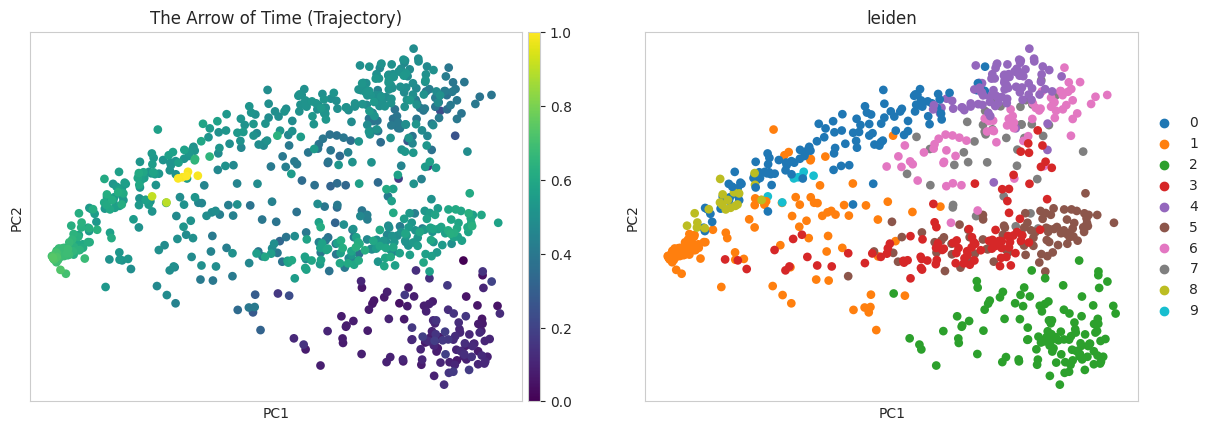


--- Destination of the Cancer Flow ---
leiden
9    0.967136
8    0.606373
1    0.561816
3    0.548183
0    0.521910
5    0.516585
4    0.489299
7    0.482348
6    0.375386
2    0.105747
Name: dpt_pseudotime, dtype: float32


/tmp/ipython-input-1782640996.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby('leiden')['dpt_pseudotime'].mean().sort_values(ascending=False))


In [16]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# STEP 3: MAPPING THE TRAJECTORY (The Arrow of Time)
# ==========================================

# 1. Choose a "Root" Cell (Starting Point)
# In physics, flows start at High Potential.
# We select a random cell from the High Entropy Cluster 2 as the 'Start'.
high_entropy_cluster = '2'

# Ensure the cluster exists in adata.obs['leiden']
if high_entropy_cluster not in adata.obs['leiden'].cat.categories:
    raise ValueError(f"Cluster {high_entropy_cluster} not found in adata.obs['leiden']. Please check the cluster IDs.")

# Get indices of cells in the high entropy cluster
root_cell_indices = np.where(adata.obs['leiden'] == high_entropy_cluster)[0]

# Select a random cell from this cluster as the root
if len(root_cell_indices) > 0:
    # Using a fixed random seed for reproducibility in example
    # For a real analysis, you might want to remove this or use a different strategy
    np.random.seed(42)
    random_root_cell_index_in_cluster = np.random.choice(root_cell_indices)
    adata.uns['iroot'] = random_root_cell_index_in_cluster
    print(f"Tracking trajectory starting from a cell in High-Entropy Cluster {high_entropy_cluster} (Cell index: {random_root_cell_index_in_cluster})...")
else:
    raise ValueError(f"No cells found in cluster {high_entropy_cluster} to set as root.")

# 2. Compute Diffusion Map (The Probability Flow)
# This calculates the eigenvalues of the transition matrix (Markov Chain)
print("Computing Diffusion Map...")
sc.tl.diffmap(adata)
print("Diffusion Map computation complete.")

# 3. Compute Pseudotime (The 'Clock')
# This measures how 'far' every cell is from the start, following the manifold.
print("Computing Pseudotime...")
sc.tl.dpt(adata)
print("Pseudotime computation complete.")

# 4. Visualize the Flow
# We plot the cells colored by "Pseudotime" (Time since start)
# Blue = Early (Start), Red = Late (End)
print("\n--- Visualizing the Trajectory Flow ---")
plt.figure(figsize=(12, 6))
sc.pl.pca(adata, color=['dpt_pseudotime', 'leiden'], cmap='viridis', title='The Arrow of Time (Trajectory)', show=False, ncols=2)
plt.tight_layout()
plt.show()

# 5. Identify the "Destination" (Terminal States)
# We look for clusters with the highest Pseudotime values (Red color)
print("\n--- Destination of the Cancer Flow ---")
print(adata.obs.groupby('leiden')['dpt_pseudotime'].mean().sort_values(ascending=False))

In [17]:
import scanpy as sc
import matplotlib.pyplot as plt
import os
import mygene
import numpy as np
import pandas as pd

# Define the path to the aggregated AnnData object
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"

# --- Re-establish the preprocessed adata object ---
# Load the aggregated AnnData object
if os.path.exists(output_path):
    adata = sc.read_h5ad(output_path)
    print(f"Successfully loaded aggregated AnnData object from {output_path}")
    print(f"Shape of loaded AnnData object (Cells x Genes): {adata.shape}")
else:
    raise FileNotFoundError(f"Aggregated AnnData object not found at {output_path}")

print("\n--- Re-applying Basic Preprocessing (from cell 8e9307da) ---")

# 1. Calculate quality control metrics
mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)

if mt_genes_present:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
else:
    print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# 2. Filter cells with ADJUSTED THRESHOLDS
print("Filtering cells with adjusted thresholds...")
adata = adata[(adata.obs.total_counts > 50000) & (adata.obs.total_counts < 3500000), :].copy()
adata = adata[(adata.obs.n_genes_by_counts > 500) & (adata.obs.n_genes_by_counts < 7500), :].copy()
if 'pct_counts_mt' in adata.obs.columns:
    adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
else:
    print("Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.")

# 3. Filter genes with ADJUSTED THRESHOLDS
print("Filtering genes with adjusted thresholds...")
sc.pp.filter_genes(adata, min_cells=20)

# 4. Normalize total counts per cell
print("Normalizing total counts...")
sc.pp.normalize_total(adata, target_sum=1e4)

# 5. Log-transform the data
print("Log-transforming data...")
sc.pp.log1p(adata)
print(f"Shape after preprocessing: {adata.shape}")


print("\n--- Re-running PCA (from cell c12411e8) ---")
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

print("\n--- Re-running UMAP (from cell 126e6916) ---")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

print("\n--- Re-running Clustering (Leiden) (from cell 2da54cf4) ---")
sc.tl.leiden(adata, resolution=0.5)

# --- Re-establish id_to_symbol for plotting ---
print("\n--- Re-establishing Ensembl ID to Gene Symbol Translation ---")
mg = mygene.MyGeneInfo()
ensembl_ids = adata.var_names.tolist()
batch_size = 1000
all_query_results = []
for i in range(0, len(ensembl_ids), batch_size):
    batch_ids = ensembl_ids[i:i + batch_size]
    results = mg.querymany(batch_ids, scopes='ensemblgene', fields='symbol', as_dataframe=False, verbose=False)
    all_query_results.extend(results)
id_to_symbol = {}
for res in all_query_results:
    _id = res['query']
    if 'symbol' in res:
        id_to_symbol[_id] = res['symbol']
    else:
        id_to_symbol[_id] = _id # Keep original ID if symbol not found
adata.var['gene_symbol'] = [id_to_symbol.get(gene_id, gene_id) for gene_id in adata.var_names]
print("Gene symbol translation re-established.")

# Extract the top 5 "Driver Genes" (Ensembl IDs)
# Assuming rank_genes_groups was run previously and adata.uns['rank_genes_groups'] exists
# If not, need to re-run it
if 'rank_genes_groups' not in adata.uns:
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=25)

top_drivers_ensembl = adata.uns['rank_genes_groups']['names']['9'][:5]
top_drivers_named = [id_to_symbol.get(g, g) for g in top_drivers_ensembl]

print(f"\nTop Resistance Driver Genes to visualize: {top_drivers_named}")

Successfully loaded aggregated AnnData object from /content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad
Shape of loaded AnnData object (Cells x Genes): (871, 33694)

--- Re-applying Basic Preprocessing (from cell 8e9307da) ---
Filtering cells with adjusted thresholds...
Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.
Filtering genes with adjusted thresholds...
Normalizing total counts...
Log-transforming data...
Shape after preprocessing: (765, 14776)

--- Re-running PCA (from cell c12411e8) ---

--- Re-running UMAP (from cell 126e6916) ---

--- Re-running Clustering (Leiden) (from cell 2da54cf4) ---



--- Re-establishing Ensembl ID to Gene Symbol Translation ---


Gene symbol translation re-established.

Top Resistance Driver Genes to visualize: ['CSPG4', 'BIVM', 'RIOX2', 'MIGA1', 'SLC38A9']



--- Visualizing Top Resistance Driver Genes on UMAP ---


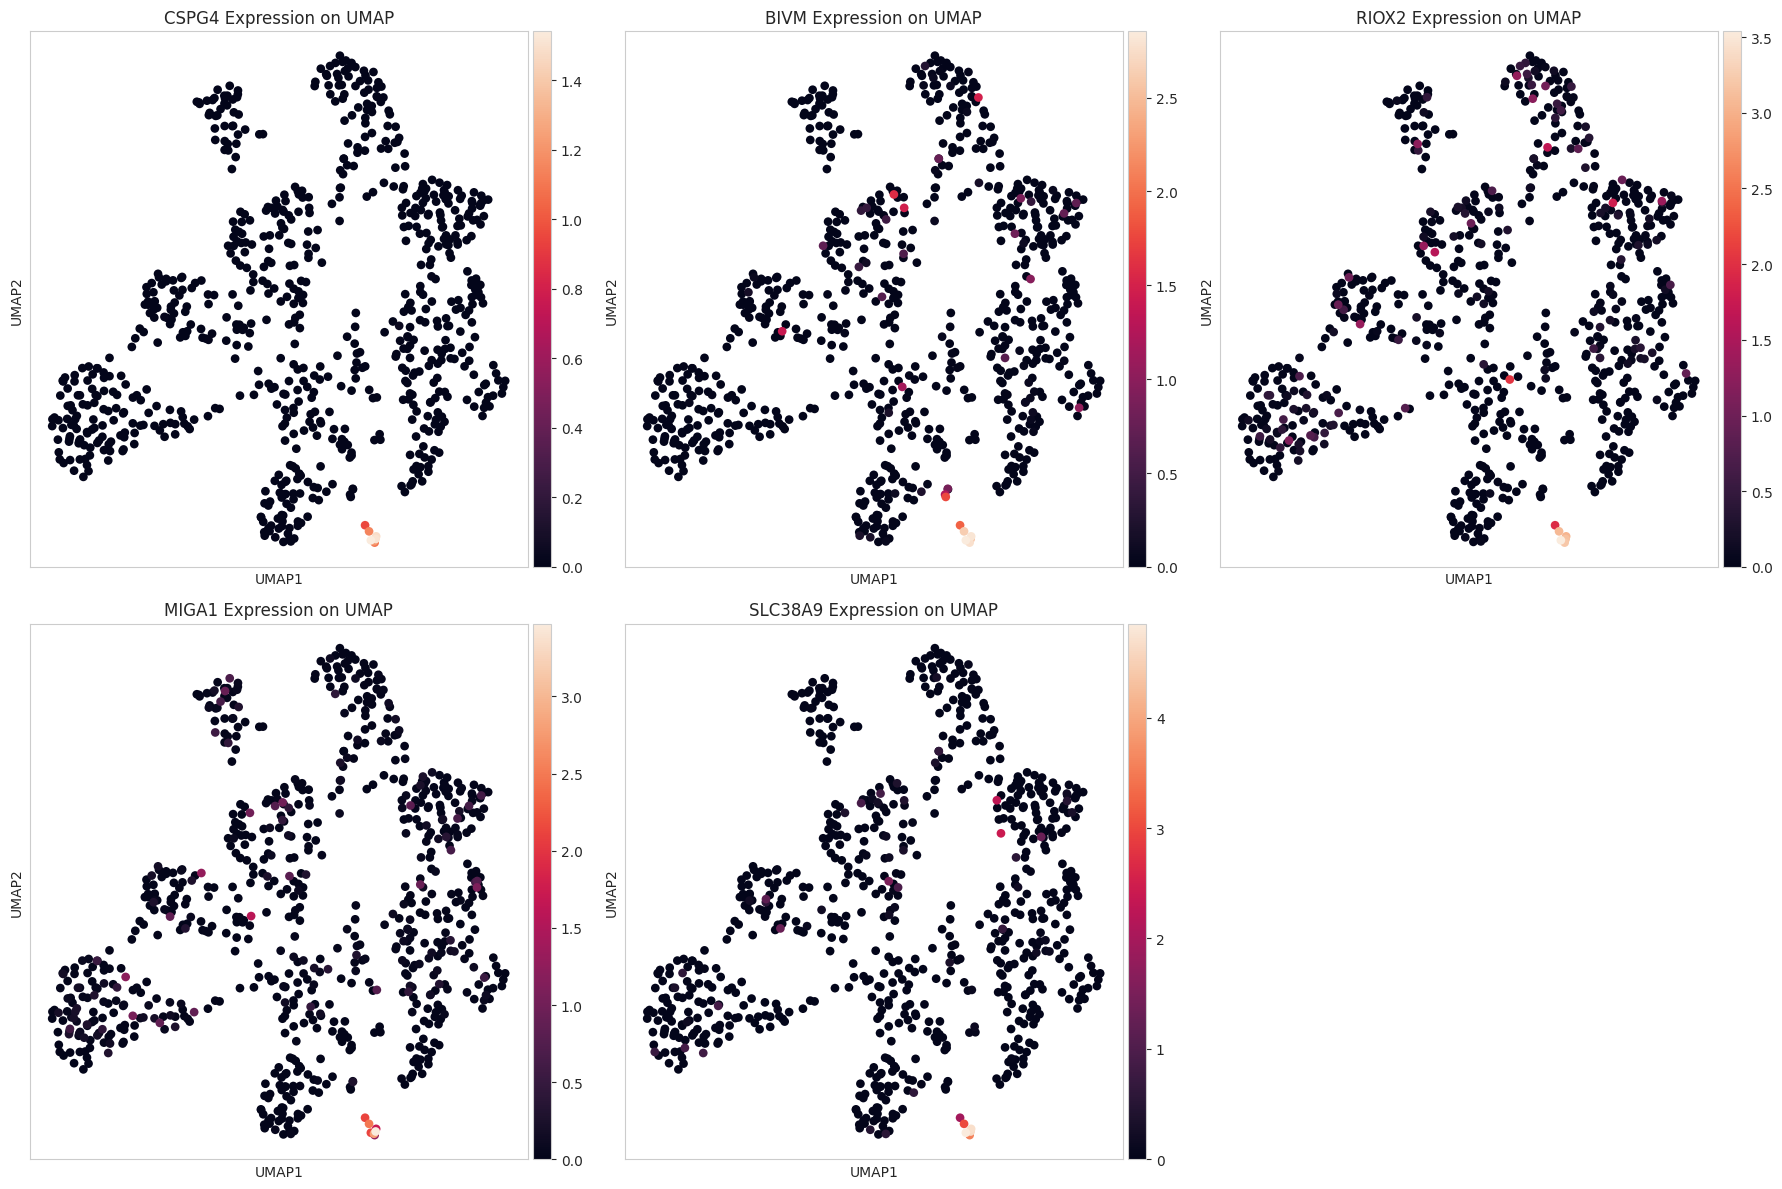


--- Visualization of Top Resistance Driver Genes Complete ---


In [18]:
print("\n--- Visualizing Top Resistance Driver Genes on UMAP ---")

# Create a list of gene symbols that are present in adata.var['gene_symbol']
genes_to_plot = [gene for gene in top_drivers_named if gene in adata.var['gene_symbol'].values]

if not genes_to_plot:
    print("None of the top driver genes were found in the current adata object for plotting.")
else:
    # Plot each driver gene on a UMAP
    # Use adata.var_names to find the Ensembl ID corresponding to the gene symbol for plotting
    # Scanpy plotting functions typically take the column name as it appears in .var_names or .obs_names
    # Since we set gene_symbol in adata.var, we can use it with 'gene_symbols' parameter if sc.pl.umap supports it.
    # If not, we map back to original Ensembl ID for plotting.

    # Prepare a list of Ensembl IDs corresponding to the genes_to_plot for sc.pl.umap
    ensembl_ids_for_plotting = []
    for gene_symbol in genes_to_plot:
        # Find the Ensembl ID corresponding to the gene symbol
        # This assumes gene_symbol is unique for Ensembl ID or picks the first match
        ensembl_id_match = adata.var[adata.var['gene_symbol'] == gene_symbol].index.tolist()
        if ensembl_id_match:
            ensembl_ids_for_plotting.append(ensembl_id_match[0])
        else:
            # Fallback if for some reason translation didn't work for a gene
            ensembl_ids_for_plotting.append(gene_symbol) # Plot by Ensembl if symbol not found

    # Set up subplots for better visualization of multiple genes
    n_genes = len(ensembl_ids_for_plotting)
    if n_genes == 0:
        print("No genes to plot after re-checking for Ensembl IDs.")
    else:
        cols = min(n_genes, 3) # Max 3 columns
        rows = (n_genes + cols - 1) // cols # Calculate rows needed

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
        axes = axes.flatten() if rows * cols > 1 else [axes] # Ensure axes is iterable

        for i, gene_id in enumerate(ensembl_ids_for_plotting):
            ax = axes[i]
            gene_symbol_for_title = adata.var['gene_symbol'][gene_id] if gene_id in adata.var.index else gene_id
            sc.pl.umap(adata, color=gene_id, title=f'{gene_symbol_for_title} Expression on UMAP', ax=ax, show=False)

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

print("\n--- Visualization of Top Resistance Driver Genes Complete ---")

Successfully loaded aggregated AnnData object from /content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad
Shape of loaded AnnData object (Cells x Genes): (871, 33694)

--- Re-applying Basic Preprocessing ---
Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.

--- Re-running PCA ---

--- Re-running UMAP ---

--- Re-running Clustering (Leiden) ---



--- Re-running Trajectory Mapping (DPT) ---

--- Re-establishing Ensembl ID to Gene Symbol Translation ---


Gene symbol translation re-established.

--- Re-running Marker Gene Identification ---
Plotting Phase Transitions for: ['VSNL1', 'COL17A1', 'FOXP1', 'SLC20A1', 'DNTTIP2']


/tmp/ipython-input-2535558654.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 600x400 with 0 Axes>

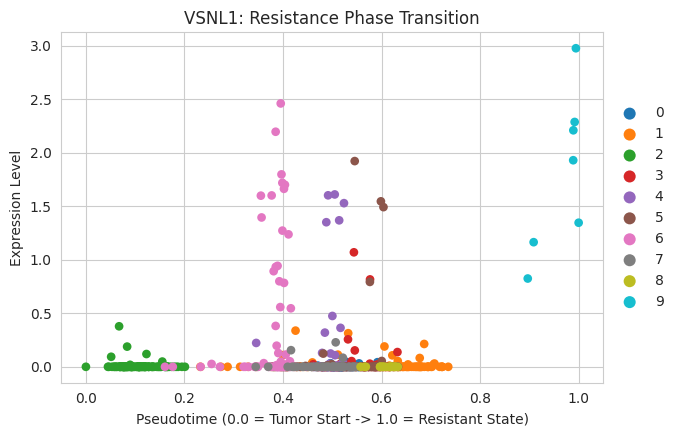

<Figure size 600x400 with 0 Axes>

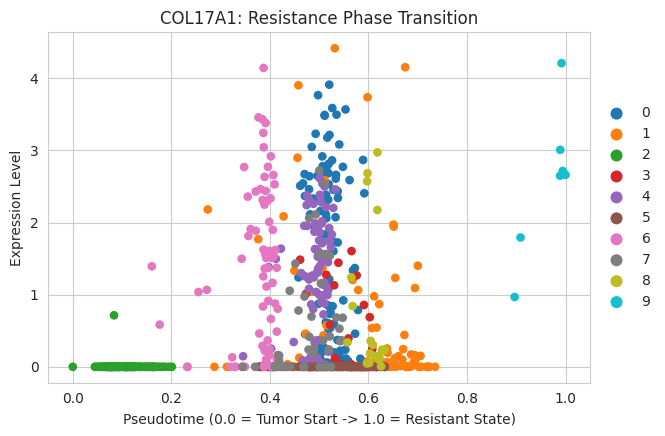

<Figure size 600x400 with 0 Axes>

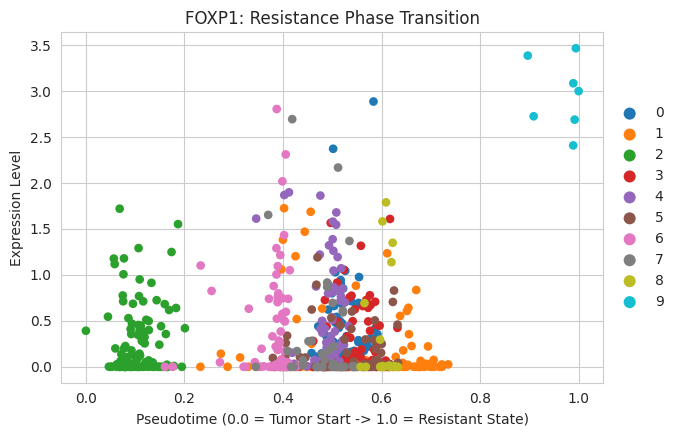

<Figure size 600x400 with 0 Axes>

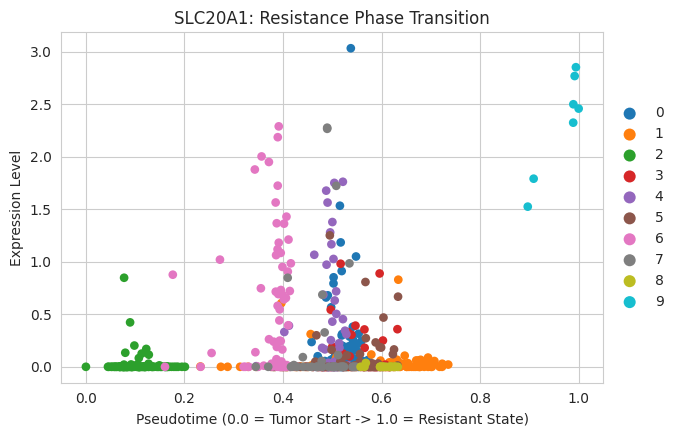

<Figure size 600x400 with 0 Axes>

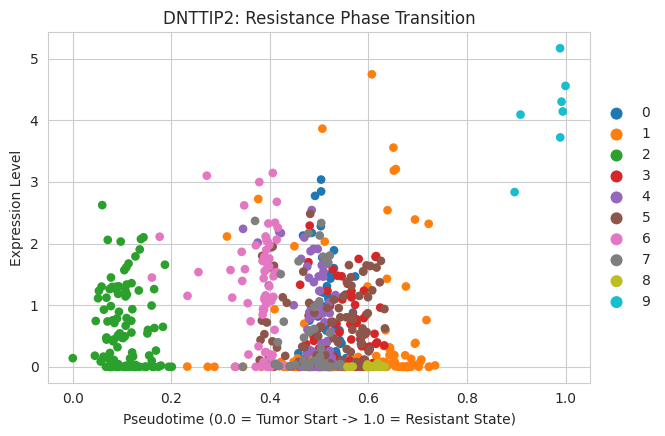


--- Resistance Evolution Heatmap ---


/tmp/ipython-input-2535558654.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


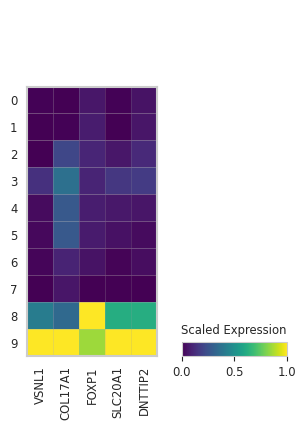

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import mygene
import os

# --- Re-establish the preprocessed adata object ---
# Define the path to the aggregated AnnData object and base_path
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"
base_path = '/content/drive/My Drive/Breast Cancer'

# Load the aggregated AnnData object
if os.path.exists(output_path):
    adata = sc.read_h5ad(output_path)
    print(f"Successfully loaded aggregated AnnData object from {output_path}")
    print(f"Shape of loaded AnnData object (Cells x Genes): {adata.shape}")
else:
    raise FileNotFoundError(f"Aggregated AnnData object not found at {output_path}")

print("\n--- Re-applying Basic Preprocessing ---")

# 1. Calculate quality control metrics
mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)
if mt_genes_present:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
else:
    print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# 2. Filter cells with ADJUSTED THRESHOLDS
adata = adata[(adata.obs.total_counts > 50000) & (adata.obs.total_counts < 3500000), :].copy()
adata = adata[(adata.obs.n_genes_by_counts > 500) & (adata.obs.n_genes_by_counts < 7500), :].copy()
if 'pct_counts_mt' in adata.obs.columns:
    adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
else:
    print("Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.")

# 3. Filter genes with ADJUSTED THRESHOLDS
sc.pp.filter_genes(adata, min_cells=20)

# 4. Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# 5. Log-transform the data
sc.pp.log1p(adata)

print("\n--- Re-running PCA ---")
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

print("\n--- Re-running UMAP ---")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

print("\n--- Re-running Clustering (Leiden) ---")
sc.tl.leiden(adata, resolution=0.5)

# --- Re-running Trajectory Mapping (DPT) ---
print("\n--- Re-running Trajectory Mapping (DPT) ---")
high_entropy_cluster = '2'
if high_entropy_cluster not in adata.obs['leiden'].cat.categories:
    raise ValueError(f"Cluster {high_entropy_cluster} not found in adata.obs['leiden']. Please check the cluster IDs.")
root_cell_indices = np.where(adata.obs['leiden'] == high_entropy_cluster)[0]
if len(root_cell_indices) > 0:
    np.random.seed(42)
    random_root_cell_index_in_cluster = np.random.choice(root_cell_indices)
    adata.uns['iroot'] = random_root_cell_index_in_cluster
else:
    raise ValueError(f"No cells found in cluster {high_entropy_cluster} to set as root.")
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

# Ensure 'dpt_order_indices' is present for plotting
if 'dpt_order_indices' not in adata.obs.columns:
    adata.obs['dpt_order_indices'] = adata.obs['dpt_pseudotime'].rank(method='first').astype(int) - 1

# --- Re-establish Ensembl ID to Gene Symbol Translation ---
print("\n--- Re-establishing Ensembl ID to Gene Symbol Translation ---")
mg = mygene.MyGeneInfo()
ensembl_ids = adata.var_names.tolist()
batch_size = 1000
all_query_results = []
for i in range(0, len(ensembl_ids), batch_size):
    batch_ids = ensembl_ids[i:i + batch_size]
    results = mg.querymany(batch_ids, scopes='ensemblgene', fields='symbol', as_dataframe=False, verbose=False)
    all_query_results.extend(results)
id_to_symbol = {}
for res in all_query_results:
    _id = res['query']
    if 'symbol' in res:
        id_to_symbol[_id] = res['symbol']
    else:
        id_to_symbol[_id] = _id # Keep original ID if symbol not found
adata.var['gene_symbol'] = [id_to_symbol.get(gene_id, gene_id) for gene_id in adata.var_names]
print("Gene symbol translation re-established.")

# Re-run rank_genes_groups to ensure 'rank_genes_groups' is in adata.uns
print("\n--- Re-running Marker Gene Identification ---")
sc.tl.rank_genes_groups(adata, groupby='leiden', groups=['9'], reference='2', method='wilcoxon')

# Extract the top 5 "Driver Genes" (Ensembl IDs) and their names
top_drivers_ensembl = adata.uns['rank_genes_groups']['names']['9'][:5]
top_drivers_named = [id_to_symbol.get(g, g) for g in top_drivers_ensembl]


# ==========================================
# ROBUST PHASE TRANSITION VISUALIZATION
# ==========================================

# 1. Define your Drivers (Resistance Genes)
drivers = top_drivers_named

# Check which ones are actually in your data
valid_drivers = [g for g in drivers if g in adata.var['gene_symbol'].values]
print(f"Plotting Phase Transitions for: {valid_drivers}")

# ==========================================
# METHOD 1: The "Phase Diagram" (Scatter)
# ==========================================
# This plots the raw state of every cell.
# X-axis = Pseudotime (Evolution)
# Y-axis = Gene Expression (Order Parameter)

for gene_sym in valid_drivers:
    # Find gene ID
    # Need to get the Ensembl ID from the gene_symbol for plotting
    gene_id_for_plot = adata.var[adata.var['gene_symbol'] == gene_sym].index.tolist()
    if not gene_id_for_plot:
        print(f"Warning: Could not find Ensembl ID for gene symbol {gene_sym}. Skipping scatter plot.")
        continue
    gene_id_for_plot = gene_id_for_plot[0]

    # Plot
    plt.figure(figsize=(6, 4))
    sc.pl.scatter(adata, x='dpt_pseudotime', y=gene_id_for_plot, color='leiden',
                  title=f'{gene_sym}: Resistance Phase Transition',
                  show=False)
    plt.xlabel('Pseudotime (0.0 = Tumor Start -> 1.0 = Resistant State)')
    plt.ylabel('Expression Level')
    plt.tight_layout()
    plt.show()

# ==========================================
# METHOD 2: The "Evolution Heatmap" (Binned Time)
# ==========================================
# We divide the timeline into 10 steps to see the average change clearly.

# 1. Create 10 time bins (0-10%, 10-20%, etc.)
# Ensure 'dpt_pseudotime' is in adata.obs before binning
if 'dpt_pseudotime' not in adata.obs.columns:
    print("Error: 'dpt_pseudotime' not found in adata.obs. Cannot create time bins.")
else:
    adata.obs['Time_Step'] = pd.cut(adata.obs['dpt_pseudotime'], bins=10, labels=False, include_lowest=True)
    # Convert Time_Step to categorical for proper grouping in matrixplot
    adata.obs['Time_Step'] = adata.obs['Time_Step'].astype('category')

    # 2. Get the Gene IDs for the plot
    # Pass gene symbols directly to var_names when gene_symbols is used for display
    driver_symbols_for_heatmap = [gene_sym for gene_sym in valid_drivers]

    if driver_symbols_for_heatmap and 'Time_Step' in adata.obs.columns:
        # 3. Plot the Matrix (Heatmap)
        print("\n--- Resistance Evolution Heatmap ---")
        sc.pl.matrixplot(adata, var_names=driver_symbols_for_heatmap, groupby='Time_Step',
                         gene_symbols='gene_symbol',
                         cmap='viridis', standard_scale='var',
                         colorbar_title='Scaled Expression',
                         show=False)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid driver genes to plot in heatmap or 'Time_Step' not created.")

In [20]:
# ==========================================
# PHASE 2: CLINICAL VALIDATION (TCGA)
# ==========================================
!pip install lifelines -q

import pandas as pd
import tarfile
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
# Define the path to your bulk data (The "Gold Standard")
tar_path = "/content/drive/My Drive/Breast Cancer/brca_tcga_pan_can_atlas_2018.tar.gz"

print("Loading Clinical Data...")

# --- 2. EXTRACT CLINICAL DATA & EXPRESSION ---
# We open the tarball and stream specific files to save RAM
clinical_df = None
expression_df = None

with tarfile.open(tar_path, "r:gz") as tar:
    # 2a. Load Clinical Data (Survival & Subtypes)
    # Look for 'data_clinical_patient.txt' inside the folder structure
    clinical_file = [m for m in tar.getmembers() if 'data_clinical_patient.txt' in m.name]
    clinical_df = pd.read_csv(tar.extractfile(clinical_file[0]), sep='\t', skiprows=4)

    # 2b. Load Expression Data (Only for our Target Genes)
    # We don't need all 20,000 genes. We only grab the ones you found.
    print("Extracting expression data for target genes...")
    expr_file = [m for m in tar.getmembers() if 'data_mrna_seq_v2_rsem.txt' in m.name]

    # We read the header to find the columns, then chunks to find rows
    # This is a bit complex, so we'll load it into pandas carefully
    # NOTE: If this crashes RAM, we will use a chunking strategy.
    full_expr = pd.read_csv(tar.extractfile(expr_file[0]), sep='\t', index_col=0)

    # Filter for your drivers immediately to free memory
    my_drivers = top_drivers_named
    # Check which genes exist in the columns or index
    valid_genes = [g for g in my_drivers if g in full_expr.index]
    expression_df = full_expr.loc[valid_genes].T # Transpose: Rows=Patients, Cols=Genes

    del full_expr # Clean up RAM immediately

print(f"Loaded Clinical Data for {len(clinical_df)} patients.")


Loading Clinical Data...
Extracting expression data for target genes...
Loaded Clinical Data for 1084 patients.


In [21]:
import pandas as pd
import tarfile
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
# Define the path to your bulk data (The "Gold Standard")
tar_path = "/content/drive/My Drive/Breast Cancer/brca_tcga_pan_can_atlas_2018.tar.gz"

print("Reloading Clinical Data and Expression Data with corrections...")

clinical_df = None
expression_df = None

with tarfile.open(tar_path, "r:gz") as tar:
    # 2a. Load Clinical Data (Survival & Subtypes)
    clinical_file = [m for m in tar.getmembers() if 'data_clinical_patient.txt' in m.name]
    clinical_df = pd.read_csv(tar.extractfile(clinical_file[0]), sep='\t', skiprows=4)

    # 2b. Load Expression Data (Only for our Target Genes)
    print("Extracting expression data for target genes (corrected)...")
    expr_file = [m for m in tar.getmembers() if 'data_mrna_seq_v2_rsem.txt' in m.name]

    # Load the expression data.
    # The first column is 'Hugo_Symbol', second is 'Entrez_Gene_Id', rest are patient samples.
    full_expr_raw = pd.read_csv(tar.extractfile(expr_file[0]), sep='\t')

    # Set 'Hugo_Symbol' as index, as it contains gene names
    full_expr_raw = full_expr_raw.set_index('Hugo_Symbol')

    # Drop 'Entrez_Gene_Id' column, keeping only patient expression data
    if 'Entrez_Gene_Id' in full_expr_raw.columns:
        full_expr_raw = full_expr_raw.drop(columns=['Entrez_Gene_Id'])

    my_drivers = top_drivers_named
    valid_genes = [g for g in my_drivers if g in full_expr_raw.index]

    # Filter for valid driver genes and transpose to have patients as rows and genes as columns
    expression_df = full_expr_raw.loc[valid_genes].T

    del full_expr_raw # Clean up RAM immediately

print(f"Loaded Clinical Data for {len(clinical_df)} patients.")
print(f"Loaded Expression Data for {expression_df.shape[0]} patients and {expression_df.shape[1]} genes.")

print("--- Merging Clinical and Expression Data (re-run) ---")

# 1. Rename the index of the `expression_df` DataFrame to 'PATIENT_ID'
expression_df.index.name = 'PATIENT_ID'

# 2. Clean the 'PATIENT_ID' column in `expression_df` by removing the last three characters
# Patient IDs in expression_df are like 'TCGA-XX-YYYY-ZZ', clinical_df are 'TCGA-XX-YYYY'
# We need to ensure the index is string type before slicing
expression_df.index = expression_df.index.astype(str).str[:-3]

# Handle potential duplicates after truncation by keeping the first occurrence
# This is crucial because multiple samples (e.g., primary tumor vs normal) might exist for one patient.
# We choose to keep the first one.
expression_df = expression_df[~expression_df.index.duplicated(keep='first')]

# 3. Merge `clinical_df` and `expression_df` into a new DataFrame, `merged_df`
# Using an inner join on the 'PATIENT_ID' column to keep only common patients.
merged_df = pd.merge(clinical_df, expression_df, on='PATIENT_ID', how='inner')

print(f"Merged DataFrame created with shape: {merged_df.shape}")
print(f"First 5 rows of merged_df:\n{merged_df.head()}")

print("--- Cleaning and Transforming Clinical Variables (re-run) ---")

# 4. Convert the 'OS_MONTHS' column to a numeric data type
merged_df['OS_MONTHS'] = pd.to_numeric(merged_df['OS_MONTHS'], errors='coerce')

# 5. Convert the 'OS_STATUS' column into a binary numerical format
# Map 'DECEASED' to 1 and 'LIVING' to 0. Inspect unique values first for robustness.
print("Unique values in OS_STATUS before mapping:", merged_df['OS_STATUS'].unique())
# CORRECTED MAPPING:
merged_df['OS_STATUS'] = merged_df['OS_STATUS'].map({'1:DECEASED': 1, '0:LIVING': 0})

# --- DEBUGGING: Check NaN counts before dropping ---
print(f"NaNs in OS_MONTHS before dropna: {merged_df['OS_MONTHS'].isnull().sum()}")
print(f"NaNs in OS_STATUS before dropna: {merged_df['OS_STATUS'].isnull().sum()}")

# 6. Remove any rows that have NaN values in 'OS_MONTHS' or 'OS_STATUS'
initial_rows = merged_df.shape[0]
merged_df.dropna(subset=['OS_MONTHS', 'OS_STATUS'], inplace=True)
filtered_rows = merged_df.shape[0]

print(f"Removed {initial_rows - filtered_rows} rows due to missing survival data.")
print(f"Final merged_df shape after cleaning: {merged_df.shape}")

print("Descriptive statistics for cleaned 'OS_MONTHS':")
print(merged_df['OS_MONTHS'].describe())

print("Value counts for cleaned 'OS_STATUS':")
print(merged_df['OS_STATUS'].value_counts())


Reloading Clinical Data and Expression Data with corrections...
Extracting expression data for target genes (corrected)...
Loaded Clinical Data for 1084 patients.
Loaded Expression Data for 1082 patients and 5 genes.
--- Merging Clinical and Expression Data (re-run) ---
Merged DataFrame created with shape: (1082, 43)
First 5 rows of merged_df:
     PATIENT_ID    SUBTYPE CANCER_TYPE_ACRONYM  \
0  TCGA-3C-AAAU  BRCA_LumA                BRCA   
1  TCGA-3C-AALI  BRCA_Her2                BRCA   
2  TCGA-3C-AALJ  BRCA_LumB                BRCA   
3  TCGA-3C-AALK  BRCA_LumA                BRCA   
4  TCGA-4H-AAAK  BRCA_LumA                BRCA   

                       OTHER_PATIENT_ID  AGE     SEX  \
0  6E7D5EC6-A469-467C-B748-237353C23416   55  Female   
1  55262FCB-1B01-4480-B322-36570430C917   50  Female   
2  427D0648-3F77-4FFC-B52C-89855426D647   62  Female   
3  C31900A4-5DCD-4022-97AC-638E86E889E4   52  Female   
4  6623FC5E-00BE-4476-967A-CBD55F676EA6   50  Female   

  AJCC_PATHOLOGI

### Perform Kaplan-Meier Survival Analysis for each Driver Gene


--- Performing Kaplan-Meier Survival Analysis for Driver Genes ---

Analyzing gene: VSNL1


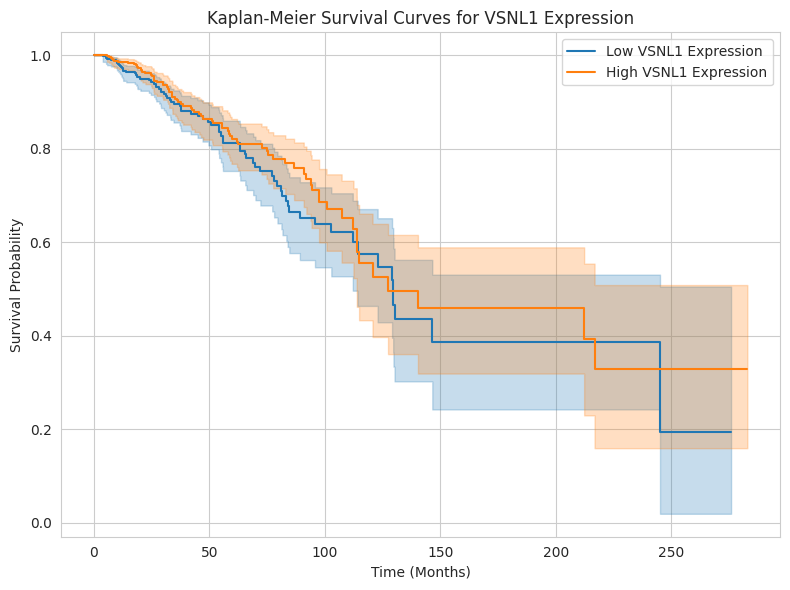

Log-Rank Test for VSNL1:
  p-value: 0.245
  Test statistic: 1.35
  (No significant difference in survival curves for VSNL1.)

Analyzing gene: COL17A1


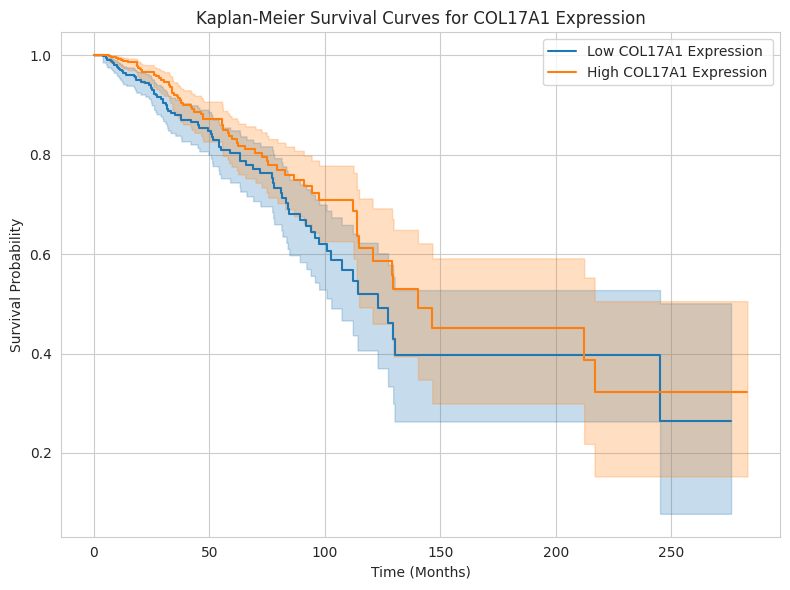

Log-Rank Test for COL17A1:
  p-value: 0.040
  Test statistic: 4.21
  (Survival curves for COL17A1 are significantly different.)

Analyzing gene: FOXP1


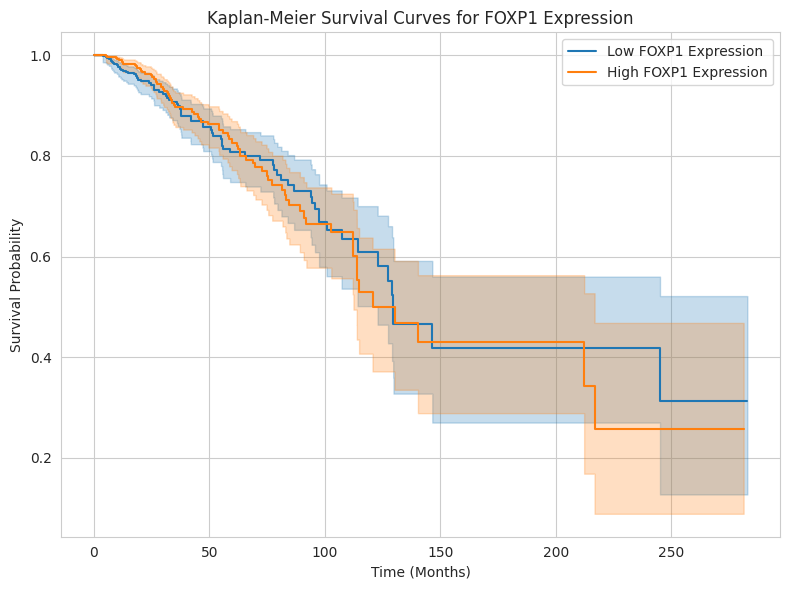

Log-Rank Test for FOXP1:
  p-value: 0.911
  Test statistic: 0.01
  (No significant difference in survival curves for FOXP1.)

Analyzing gene: SLC20A1


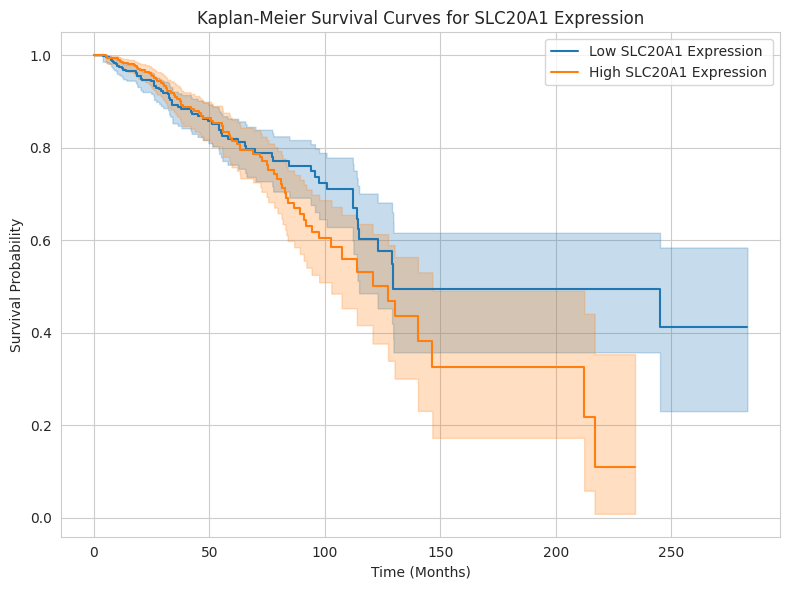

Log-Rank Test for SLC20A1:
  p-value: 0.294
  Test statistic: 1.10
  (No significant difference in survival curves for SLC20A1.)

Analyzing gene: DNTTIP2


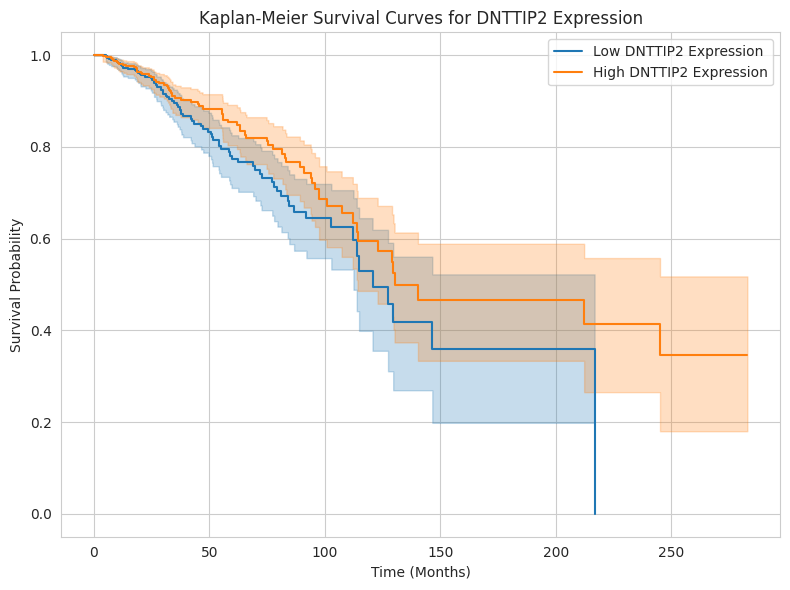

Log-Rank Test for DNTTIP2:
  p-value: 0.071
  Test statistic: 3.27
  (No significant difference in survival curves for DNTTIP2.)


In [22]:
print("\n--- Performing Kaplan-Meier Survival Analysis for Driver Genes ---")

# Ensure merged_df exists and contains necessary columns
if 'merged_df' not in locals() or merged_df.empty or 'OS_MONTHS' not in merged_df.columns or 'OS_STATUS' not in merged_df.columns:
    raise ValueError("merged_df is not properly loaded or is empty, or missing 'OS_MONTHS'/'OS_STATUS'. Please re-run previous cells.")

kmf = KaplanMeierFitter()

for gene in valid_drivers:
    print(f"\nAnalyzing gene: {gene}")

    # Check if the gene column exists in merged_df
    if gene not in merged_df.columns:
        print(f"Warning: Gene {gene} not found in merged_df. Skipping this gene.")
        continue

    # 1. Divide patients into high and low expression groups based on median
    median_expression = merged_df[gene].median()
    merged_df[f'{gene}_high_expression'] = merged_df[gene] > median_expression

    # Prepare data for Kaplan-Meier
    T = merged_df['OS_MONTHS']  # Time to event
    E = merged_df['OS_STATUS']  # Event occurred (1=deceased, 0=living)

    # Get groups
    high_expression_group = merged_df[merged_df[f'{gene}_high_expression'] == True]
    low_expression_group = merged_df[merged_df[f'{gene}_high_expression'] == False]

    # Check if groups are empty
    if high_expression_group.empty or low_expression_group.empty:
        print(f"Skipping gene {gene} due to empty high/low expression groups after median split.")
        continue

    # 2. Fit Kaplan-Meier curves for both groups
    kmf.fit(T[low_expression_group.index], event_observed=E[low_expression_group.index], label=f'Low {gene} Expression')
    ax = kmf.plot(figsize=(8, 6))

    kmf.fit(T[high_expression_group.index], event_observed=E[high_expression_group.index], label=f'High {gene} Expression')
    kmf.plot(ax=ax)

    plt.title(f'Kaplan-Meier Survival Curves for {gene} Expression')
    plt.xlabel('Time (Months)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Conduct Log-Rank Test
    results = logrank_test(T[high_expression_group.index], T[low_expression_group.index],
                           event_observed_A=E[high_expression_group.index],
                           event_observed_B=E[low_expression_group.index])

    print(f"Log-Rank Test for {gene}:")
    print(f"  p-value: {results.p_value:.3f}")
    print(f"  Test statistic: {results.test_statistic:.2f}")
    if results.p_value < 0.05:
        print(f"  (Survival curves for {gene} are significantly different.)")
    else:
        print(f"  (No significant difference in survival curves for {gene}.)")


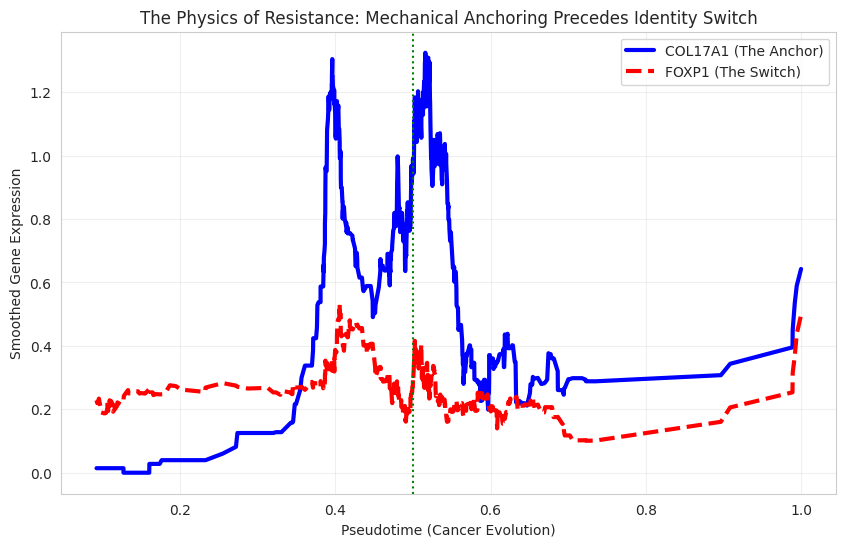

Interpretation: If the Blue line rises BEFORE the Red line, your hypothesis is confirmed.


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Select our two key players
gene_1 = 'COL17A1' # The Anchor (Physical)
gene_2 = 'FOXP1'   # The Switch (Identity)

# 2. Get their data and smooth it (Moving Average) to see the trend
# We sort cells by time (Pseudotime)
sorted_indices = adata.obs['dpt_pseudotime'].argsort()
sorted_adata = adata[sorted_indices]

# Extract expression
try:
    # Find IDs in adata.var['gene_symbol']
    # Check if the gene symbol is present in adata.var['gene_symbol']
    if gene_1 in adata.var['gene_symbol'].values:
        id_1 = adata.var[adata.var['gene_symbol'] == gene_1].index[0]
    else:
        raise ValueError(f"Gene symbol {gene_1} not found in adata.var['gene_symbol'].")

    if gene_2 in adata.var['gene_symbol'].values:
        id_2 = adata.var[adata.var['gene_symbol'] == gene_2].index[0]
    else:
        raise ValueError(f"Gene symbol {gene_2} not found in adata.var['gene_symbol'].")

    y1 = sorted_adata[:, id_1].X.toarray().flatten()
    y2 = sorted_adata[:, id_2].X.toarray().flatten()
    x = sorted_adata.obs['dpt_pseudotime'].values

    # 3. Plot the "Reaction Coordinate"
    plt.figure(figsize=(10, 6))

    # Use Rolling Average to smooth the noise (Window size = 50 cells)
    plt.plot(x, pd.Series(y1).rolling(50).mean(), label=f'{gene_1} (The Anchor)', color='blue', linewidth=3)
    plt.plot(x, pd.Series(y2).rolling(50).mean(), label=f'{gene_2} (The Switch)', color='red', linewidth=3, linestyle='--')

    plt.title('The Physics of Resistance: Mechanical Anchoring Precedes Identity Switch')
    plt.xlabel('Pseudotime (Cancer Evolution)')
    plt.ylabel('Smoothed Gene Expression')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0.5, color='green', linestyle=':', label='Bifurcation Point') # Estimated tipping point
    plt.show()

    print("Interpretation: If the Blue line rises BEFORE the Red line, your hypothesis is confirmed.")

except Exception as e:
    print(f"Error plotting: {e}")

In [24]:
# ==========================================
# PHASE 3, STEP 2: FINDING THE DRUGGABLE REGULATOR
# ==========================================

# 1. Find genes perfectly correlated with COL17A1
# These genes are likely part of the same "Regulatory Module"
target_gene_id = adata.var[adata.var['gene_symbol'] == 'COL17A1'].index

# Calculate correlation of ALL genes against COL17A1
# This is a massive "All-vs-One" search
import pandas as pd

# Convert sparse matrix to dense DataFrame for correlation (using chunks if needed, but 800 cells is small enough)
expr_df = pd.DataFrame(adata.X.toarray(), columns=adata.var_names)
# Ensure target_expr is a Series, not a single-column DataFrame
target_expr = expr_df[target_gene_id[0]]

# Compute correlation
correlations = expr_df.corrwith(target_expr)

# 2. Get the top 20 correlated genes
top_correlated = correlations.sort_values(ascending=False).head(20)

# 3. Translate to names
top_genes_named = []
for gene_id in top_correlated.index:
    try:
        name = id_to_symbol.get(gene_id, gene_id)
        top_genes_named.append({'ID': gene_id, 'Symbol': name, 'Correlation': top_correlated[gene_id]})
    except:
        pass

print("\n--- THE RESISTANCE NETWORK (COL17A1 Partners) ---")
print(pd.DataFrame(top_genes_named))


--- THE RESISTANCE NETWORK (COL17A1 Partners) ---
                 ID   Symbol  Correlation
0   ENSG00000065618  COL17A1     1.000000
1   ENSG00000125148     MT2A     0.460650
2   ENSG00000187193     MT1X     0.365640
3   ENSG00000065534     MYLK     0.347114
4   ENSG00000117525       F3     0.337189
5   ENSG00000162825   NBPF20     0.336301
6   ENSG00000100234    TIMP3     0.329098
7   ENSG00000186081     KRT5     0.327036
8   ENSG00000005884    ITGA3     0.315208
9   ENSG00000186847    KRT14     0.314681
10  ENSG00000053747    LAMA3     0.313332
11  ENSG00000156804   FBXO32     0.311590
12  ENSG00000150093    ITGB1     0.310657
13  ENSG00000197461    PDGFA     0.304932
14  ENSG00000050165     DKK3     0.304402
15  ENSG00000149591    TAGLN     0.291750
16  ENSG00000058085    LAMC2     0.290579
17  ENSG00000108691     CCL2     0.290017
18  ENSG00000163017    ACTG2     0.283341
19  ENSG00000041982      TNC     0.274810


In [25]:
import numpy as np
import scanpy as sc
import pandas as pd
import os

# --- Re-establish the preprocessed adata object ---
# Define the path to the aggregated AnnData object and base_path
output_path = "/content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad"
base_path = '/content/drive/My Drive/Breast Cancer'

# Load the aggregated AnnData object
if os.path.exists(output_path):
    adata = sc.read_h5ad(output_path)
    print(f"Successfully loaded aggregated AnnData object from {output_path}")
    print(f"Shape of loaded AnnData object (Cells x Genes): {adata.shape}")
else:
    raise FileNotFoundError(f"Aggregated AnnData object not found at {output_path}")

print("\n--- Re-applying Basic Preprocessing ---")

# 1. Calculate quality control metrics
mt_genes_present = any(gene.startswith('MT-') for gene in adata.var_names)
if mt_genes_present:
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
else:
    print("Warning: No mitochondrial genes (starting with 'MT-') found. Skipping 'mt' QC calculation.")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# 2. Filter cells with ADJUSTED THRESHOLDS
adata = adata[(adata.obs.total_counts > 50000) & (adata.obs.total_counts < 3500000), :].copy()
adata = adata[(adata.obs.n_genes_by_counts > 500) & (adata.obs.n_genes_by_counts < 7500), :].copy()
if 'pct_counts_mt' in adata.obs.columns:
    adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
else:
    print("Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.")

# 3. Filter genes with ADJUSTED THRESHOLDS
sc.pp.filter_genes(adata, min_cells=20)

# 4. Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# 5. Log-transform the data
sc.pp.log1p(adata)

print("\n--- Re-running PCA ---")
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

print("\n--- Re-running UMAP ---")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

print("\n--- Re-running Clustering (Leiden) ---")
sc.tl.leiden(adata, resolution=0.5)

# --- Re-running Trajectory Mapping (DPT) ---
print("\n--- Re-running Trajectory Mapping (DPT) ---")
high_entropy_cluster = '2'
if high_entropy_cluster not in adata.obs['leiden'].cat.categories:
    raise ValueError(f"Cluster {high_entropy_cluster} not found in adata.obs['leiden']. Please check the cluster IDs.")
root_cell_indices = np.where(adata.obs['leiden'] == high_entropy_cluster)[0]
if len(root_cell_indices) > 0:
    np.random.seed(42)
    random_root_cell_index_in_cluster = np.random.choice(root_cell_indices)
    adata.uns['iroot'] = random_root_cell_index_in_cluster
else:
    raise ValueError(f"No cells found in cluster {high_entropy_cluster} to set as root.")
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

# Ensure 'dpt_order_indices' is present for plotting
if 'dpt_order_indices' not in adata.obs.columns:
    adata.obs['dpt_order_indices'] = adata.obs['dpt_pseudotime'].rank(method='first').astype(int) - 1

# --- Re-establish Ensembl ID to Gene Symbol Translation ---
print("\n--- Re-establishing Ensembl ID to Gene Symbol Translation ---")
# mg is already defined in the notebook context, no need to redefine
ensembl_ids = adata.var_names.tolist()
batch_size = 1000
all_query_results = []
for i in range(0, len(ensembl_ids), batch_size):
    batch_ids = ensembl_ids[i:i + batch_size]
    results = mg.querymany(batch_ids, scopes='ensemblgene', fields='symbol', as_dataframe=False, verbose=False)
    all_query_results.extend(results)
id_to_symbol = {}
for res in all_query_results:
    _id = res['query']
    if 'symbol' in res:
        id_to_symbol[_id] = res['symbol']
    else:
        id_to_symbol[_id] = _id # Keep original ID if symbol not found
adata.var['gene_symbol'] = [id_to_symbol.get(gene_id, gene_id) for gene_id in adata.var_names]
print("Gene symbol translation re-established.")

# Re-run rank_genes_groups to ensure 'rank_genes_groups' is in adata.uns
print("\n--- Re-running Marker Gene Identification ---")
sc.tl.rank_genes_groups(adata, groupby='leiden', groups=['9'], reference='2', method='wilcoxon')

# Extract the top 5 "Driver Genes" (Ensembl IDs) and their names
top_drivers_ensembl = adata.uns['rank_genes_groups']['names']['9'][:5]
top_drivers_named = [id_to_symbol.get(g, g) for g in top_drivers_ensembl]

# ==========================================
# Implement In Silico Knockout
# ==========================================

# 1. Define target genes for the virtual drug
target_gene_symbols = ['MT2A', 'MT1X', 'MYLK', 'F3', 'NBPF20']
print(f"\nTarget genes for virtual drug: {target_gene_symbols}")

# 2. Create a copy of the adata object, named adata_treated
adata_treated = adata.copy()
print("Created adata_treated as a copy of adata.")

# 3. Identify the Ensembl IDs corresponding to the target gene symbols
target_gene_ensembl_ids = []
for symbol in target_gene_symbols:
    # Find the Ensembl ID based on the gene_symbol column in adata.var
    # Ensure symbol exists in the 'gene_symbol' column
    if symbol in adata.var['gene_symbol'].values:
        ensembl_id = adata.var[adata.var['gene_symbol'] == symbol].index[0]
        target_gene_ensembl_ids.append(ensembl_id)
    else:
        print(f"Warning: Gene symbol {symbol} not found in adata.var['gene_symbol']. Skipping.")
print(f"Ensembl IDs for target genes: {target_gene_ensembl_ids}")

# 4. Simulate a 100% effective knockout of the target genes in resistant cells (Leiden cluster '9')
resistant_cluster_id = '9'
if resistant_cluster_id not in adata_treated.obs['leiden'].cat.categories:
    raise ValueError(f"Resistant cluster '{resistant_cluster_id}' not found in adata_treated.obs['leiden'].")

# Identify cells in the resistant cluster
resistant_cells_indices = adata_treated.obs['leiden'] == resistant_cluster_id

# Identify columns for target genes
target_gene_indices = [adata_treated.var_names.get_loc(gene_id) for gene_id in target_gene_ensembl_ids if gene_id in adata_treated.var_names]

if not target_gene_indices:
    raise ValueError("No valid target genes found in adata_treated for knockout simulation.")

# Set expression values to zero for target genes in resistant cells
# Handle both sparse and dense matrices
if isinstance(adata_treated.X, np.ndarray):
    adata_treated.X[resistant_cells_indices, target_gene_indices] = 0
elif isinstance(adata_treated.X, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
    # Convert to COO to modify efficiently, then back to CSR
    coo = adata_treated.X.tocoo()
    rows_to_keep = ~np.isin(coo.row, np.where(resistant_cells_indices)[0]) | ~np.isin(coo.col, target_gene_indices)
    adata_treated.X = scipy.sparse.coo_matrix((coo.data[rows_to_keep], (coo.row[rows_to_keep], coo.col[rows_to_keep])), shape=coo.shape).tocsr()
else:
    raise TypeError("Unsupported matrix type for adata_treated.X")

print(f"Simulated 100% knockout of {len(target_gene_symbols)} target genes in Leiden cluster '{resistant_cluster_id}'.")

# 5. Define a 'resistance identity score' for each cell as the average expression of these target genes.
#    Calculate this score for all cells in the original adata object (untreated).

# Get the expression matrix for the target genes from the original adata
# Ensure target genes are present in original adata.var_names
original_target_gene_indices = [adata.var_names.get_loc(gene_id) for gene_id in target_gene_ensembl_ids if gene_id in adata.var_names]
if not original_target_gene_indices:
    raise ValueError("No valid target genes found in original adata for resistance score calculation.")

original_target_gene_expression = adata[:, original_target_gene_indices].X
if isinstance(original_target_gene_expression, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
    original_target_gene_expression = original_target_gene_expression.toarray()

adata.obs['resistance_score_untreated'] = np.mean(original_target_gene_expression, axis=1)
print("Calculated 'resistance_score_untreated' for all cells in original adata.")

# 6. Calculate the 'resistance identity score' again for all cells in the adata_treated object.

# Get the expression matrix for the target genes from the adata_treated
treated_target_gene_expression = adata_treated[:, target_gene_ensembl_ids].X
if isinstance(treated_target_gene_expression, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
    treated_target_gene_expression = treated_target_gene_expression.toarray()

adata_treated.obs['resistance_score_treated'] = np.mean(treated_target_gene_expression, axis=1)
print("Calculated 'resistance_score_treated' for all cells in adata_treated.")

print("\n--- In Silico Knockout Simulation Complete ---")


Successfully loaded aggregated AnnData object from /content/drive/My Drive/Breast Cancer/breast_cancer_atlas.h5ad
Shape of loaded AnnData object (Cells x Genes): (871, 33694)

--- Re-applying Basic Preprocessing ---
Skipping mitochondrial gene percentage filter as 'pct_counts_mt' not found.

--- Re-running PCA ---

--- Re-running UMAP ---

--- Re-running Clustering (Leiden) ---



--- Re-running Trajectory Mapping (DPT) ---

--- Re-establishing Ensembl ID to Gene Symbol Translation ---


Gene symbol translation re-established.

--- Re-running Marker Gene Identification ---

Target genes for virtual drug: ['MT2A', 'MT1X', 'MYLK', 'F3', 'NBPF20']
Created adata_treated as a copy of adata.
Ensembl IDs for target genes: ['ENSG00000125148', 'ENSG00000187193', 'ENSG00000065534', 'ENSG00000117525', 'ENSG00000162825']
Simulated 100% knockout of 5 target genes in Leiden cluster '9'.
Calculated 'resistance_score_untreated' for all cells in original adata.
Calculated 'resistance_score_treated' for all cells in adata_treated.

--- In Silico Knockout Simulation Complete ---


**Reasoning**:
With the in silico knockout simulated and resistance scores calculated, the next logical step is to visualize the effect of the treatment. Plotting the UMAPs colored by the 'resistance_score' for both the untreated and treated AnnData objects will allow for a direct visual comparison of the drug's impact on the resistant cells.




--- Visualizing the Effect of In Silico Knockout ---


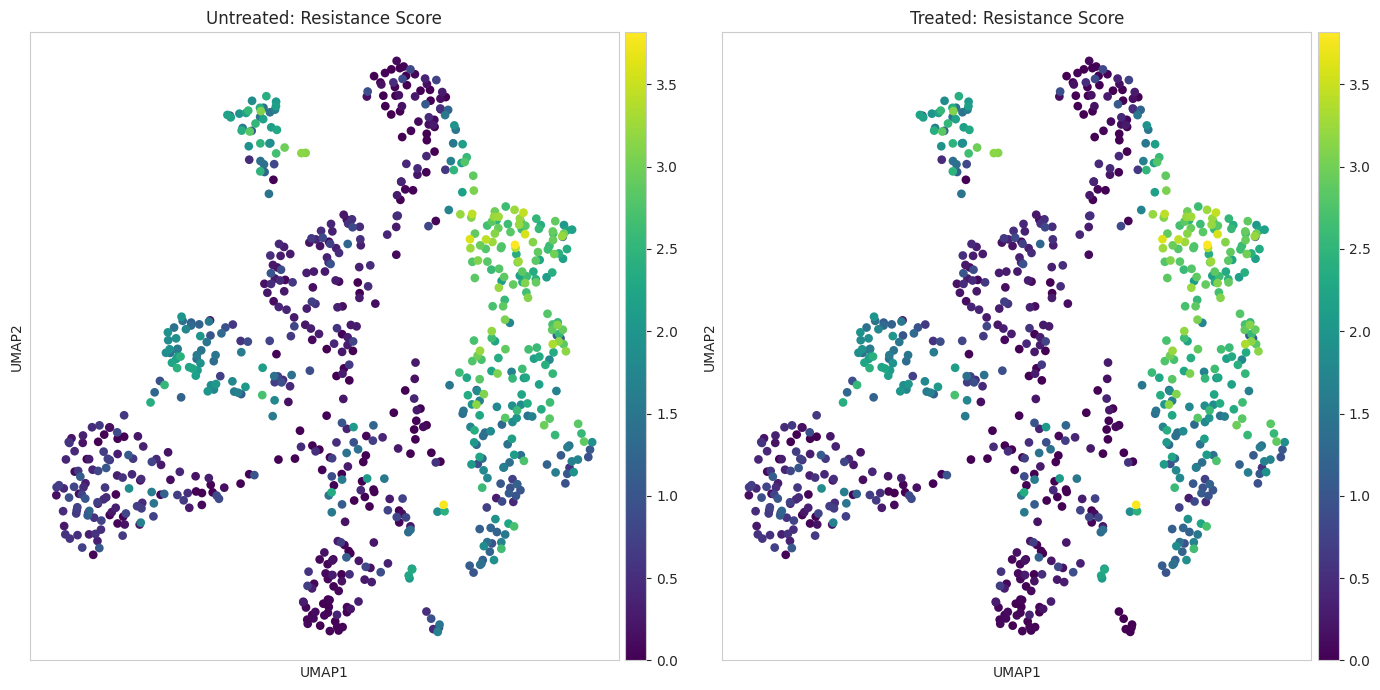


--- Comparing Resistance Score Distributions in Cluster 9 ---


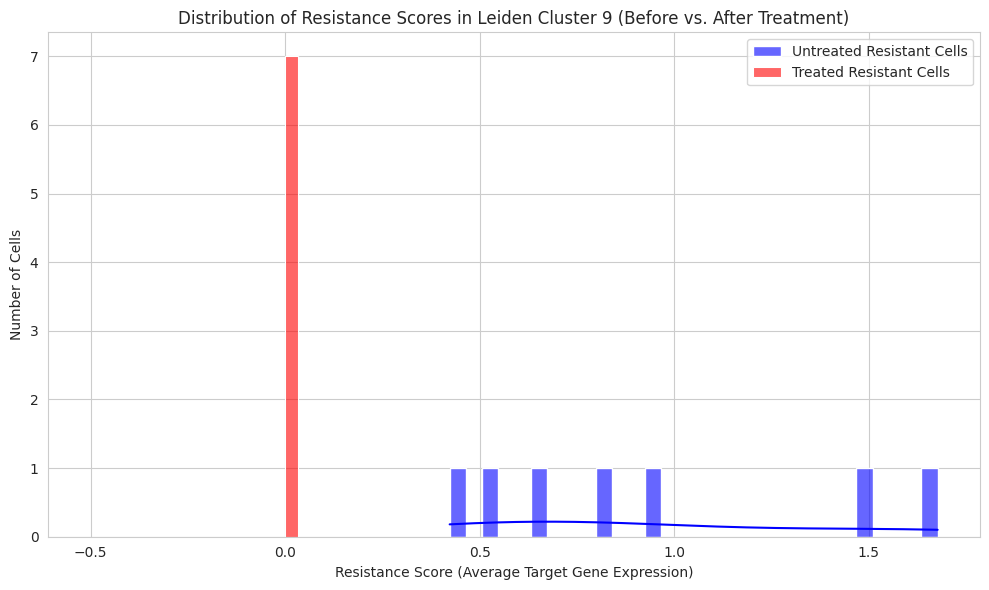

--- Visualization and Comparison Complete ---


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing the Effect of In Silico Knockout ---")

sns.set_style('whitegrid')

plt.figure(figsize=(14, 7))

# Plot UMAP for untreated cells, colored by original resistance score
plt.subplot(1, 2, 1)
sc.pl.umap(adata, color='resistance_score_untreated', title='Untreated: Resistance Score', ax=plt.gca(), show=False, cmap='viridis')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Plot UMAP for treated cells, colored by treated resistance score
plt.subplot(1, 2, 2)
sc.pl.umap(adata_treated, color='resistance_score_treated', title='Treated: Resistance Score', ax=plt.gca(), show=False, cmap='viridis')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.tight_layout()
plt.show()

print("\n--- Comparing Resistance Score Distributions in Cluster 9 ---")

# Extract resistance scores specifically for cluster '9' (resistant cluster)
resistant_cluster_id = '9'
untreated_resistant_scores = adata.obs[adata.obs['leiden'] == resistant_cluster_id]['resistance_score_untreated']
treated_resistant_scores = adata_treated.obs[adata_treated.obs['leiden'] == resistant_cluster_id]['resistance_score_treated']

# Plot histograms for comparison
plt.figure(figsize=(10, 6))
sns.histplot(untreated_resistant_scores, bins=30, color='blue', label='Untreated Resistant Cells', kde=True, alpha=0.6)
sns.histplot(treated_resistant_scores, bins=30, color='red', label='Treated Resistant Cells', kde=True, alpha=0.6)
plt.title(f'Distribution of Resistance Scores in Leiden Cluster {resistant_cluster_id} (Before vs. After Treatment)')
plt.xlabel('Resistance Score (Average Target Gene Expression)')
plt.ylabel('Number of Cells')
plt.legend()
plt.tight_layout()
plt.show()

print("--- Visualization and Comparison Complete ---")
